## National Phenolgy Network Data Exploration

I am downloading data from the Observation Portal (https://data.usanpn.org/observations/get-started), with the following selections:
* Data Type: Status and Intensity
* Date Range: 1/1/2009 - Current (5/28/2020)
* Location: CA
* Species: Forbs
* Phenophases: Flowers, Fruits, Leaves
* Partner Groups: No Selection
* Source Datasets: No Selection
* Output Fields: All
* Ancillary Data: None

Soil data for CA from here:
* https://gdg.sc.egov.usda.gov/GDGOrder.aspx?order=QuickState

In [390]:
import pandas as pd
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches

import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

import pyproj
import rasterio

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

import missingno as msno
from datetime import date, timedelta
from daylength import daylength

import pickle

## Data Cleaning

In [131]:
data = pd.read_csv('status_intensity_observation_data.csv', low_memory=False)
data2 = pd.read_csv('npn_2009-2014/status_intensity_observation_data.csv', low_memory=False)
data3 = pd.read_csv('npn-west_states/status_intensity_observation_data.csv', low_memory=False)

data = pd.concat([data,data2,data3],ignore_index=True)

In [132]:
data.replace(-9999., np.nan, inplace=True)

In [26]:
data.loc[0:1,'Site_ID':]

,Site_ID,Site_Name,Latitude,Longitude,Elevation_in_Meters,State,Species_ID,Genus,Species,Common_Name,...,Tmin_Fall,Tmin,Tmin_in_F,Prcp_Winter,Prcp_Spring,Prcp_Summer,Prcp_Fall,Prcp,Accum_Prcp,Daylength
0,1051,Villager Nursery,39.326412,-120.195107,1793.0,CA,36,Syringa,vulgaris,common lilac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1051,Villager Nursery,39.326412,-120.195107,1793.0,CA,36,Syringa,vulgaris,common lilac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mostly missing columns: Dataset_ID, Patch, Abundance Value
Partially missing: UpdatedBy_Person_ID (50%), Intensity Category ID (80%), Species Specific Info ID (90%)

AGDD - Daylength is all at about 80%

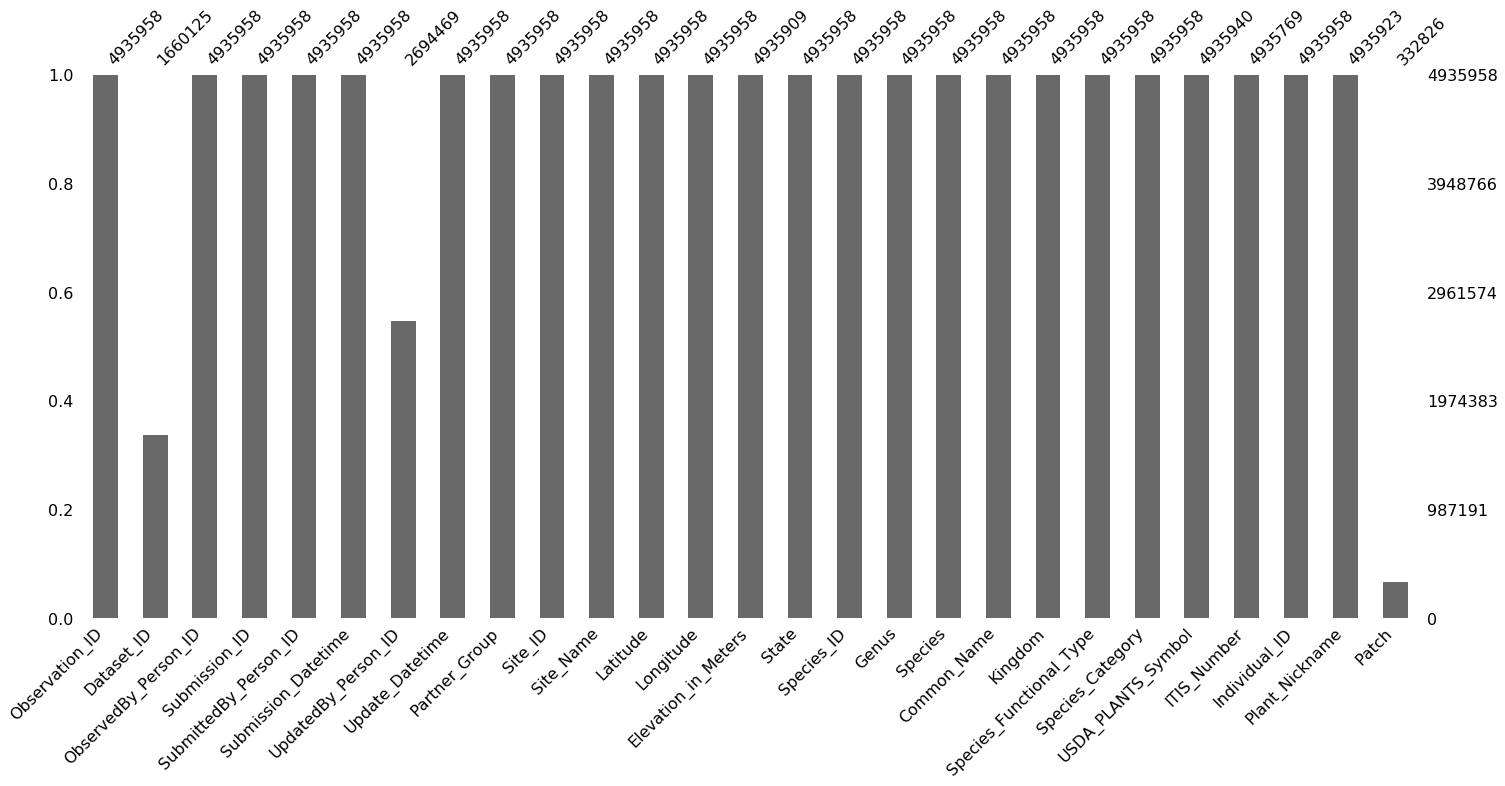

In [126]:
msno.bar(data.loc[:,:'Patch'])

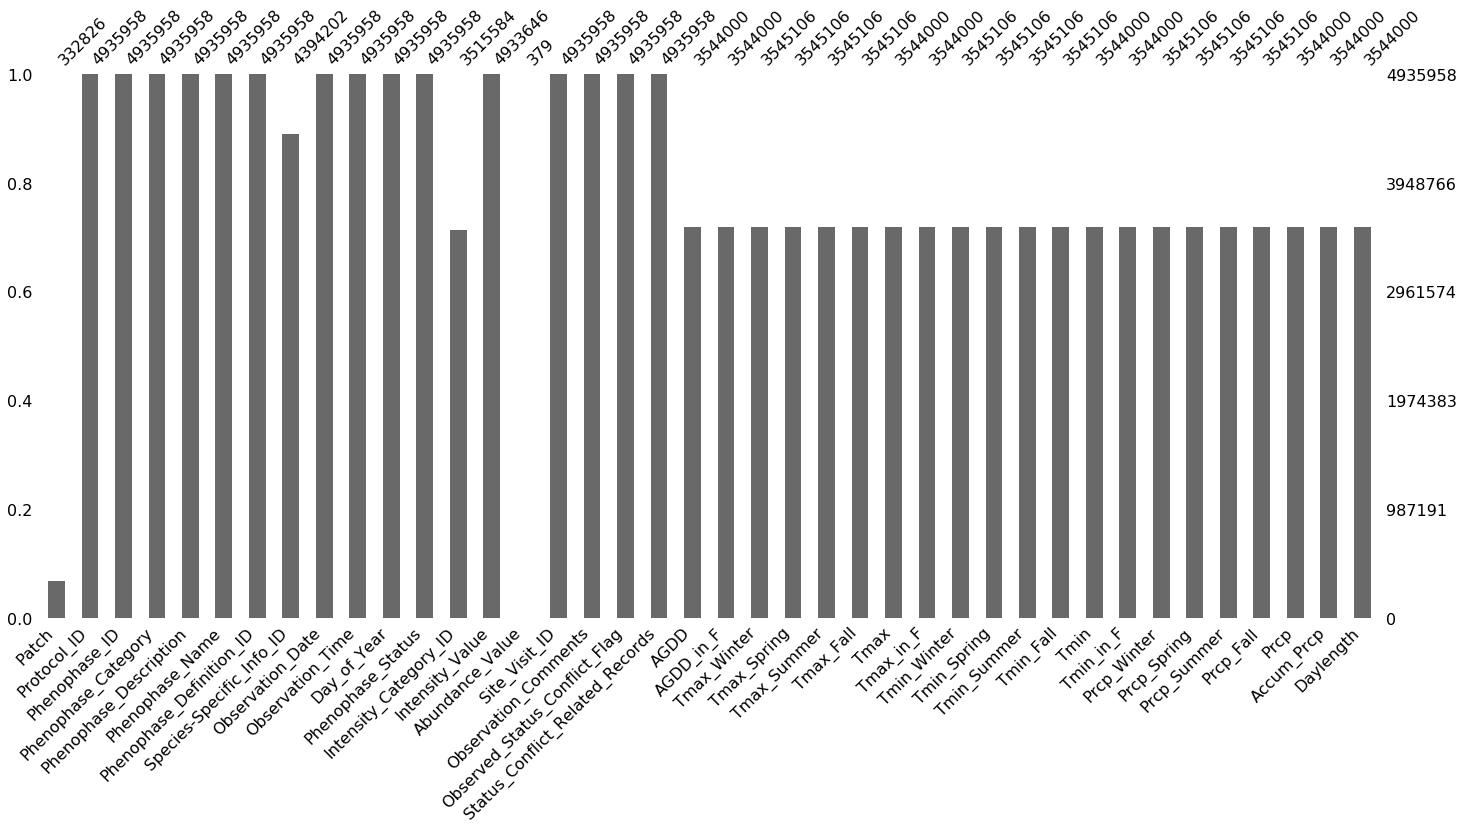

In [127]:
msno.bar(data.loc[:,'Patch':])
#msno.bar(data.loc[:100,:10])

In [133]:
data['date'] = pd.to_datetime(data.Observation_Date,format='%Y-%m-%d',errors='coerce')
data.dropna(subset=['date'],inplace=True)

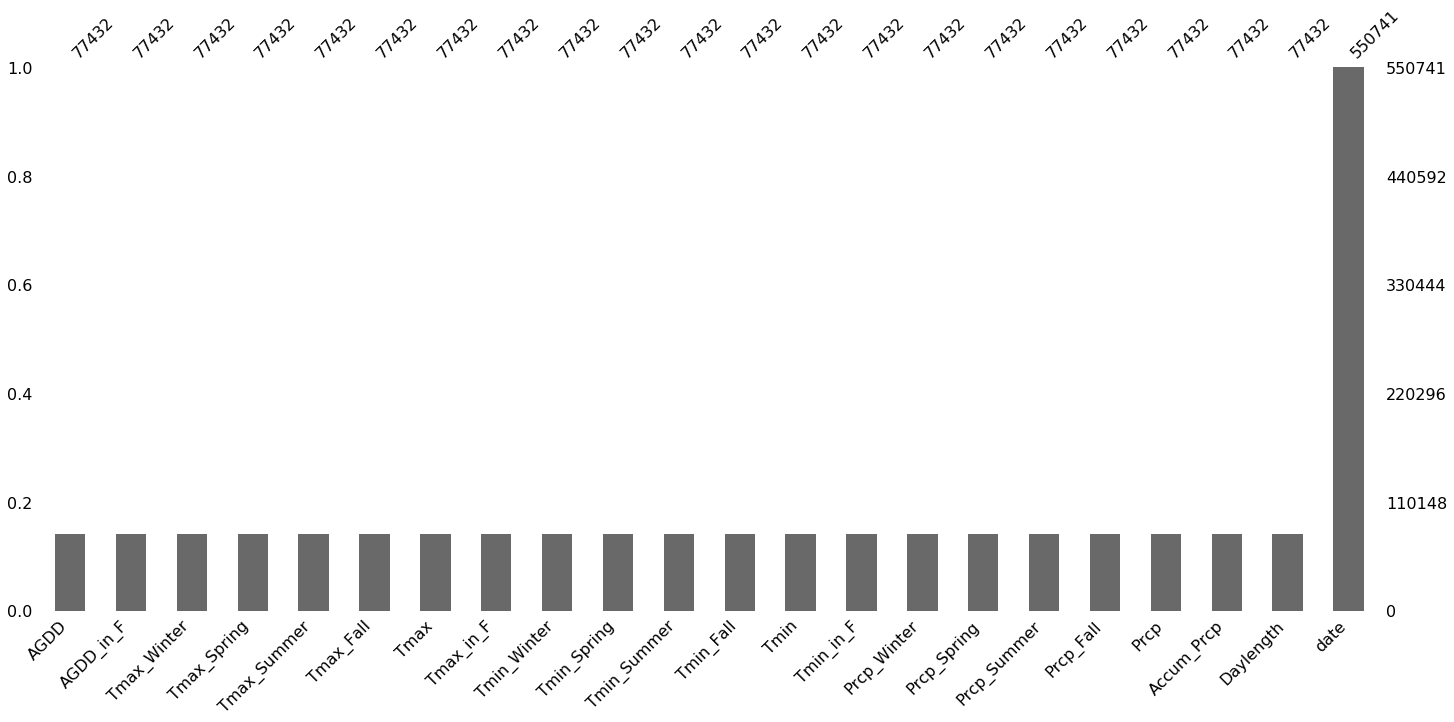

In [34]:
# it seems that weather data stopped being included sometime around 2017.  Inclusion rate is very high before 2017.
msno.bar(data[data.date.dt.year>2017].loc[:,'AGDD':])

In [134]:
data = data[['date','State','Submission_ID','Latitude','Longitude','Elevation_in_Meters','Genus','Species','Common_Name', \
      'Species_Functional_Type','Species_Category','Individual_ID','Phenophase_ID','Phenophase_Category', \
      'Phenophase_Description','Phenophase_Name','Phenophase_Status','Observation_Date','Day_of_Year', \
       'Intensity_Value','AGDD','Accum_Prcp']]


In [152]:
# Now save this df for quick retrieval
#data.to_pickle('npn_dataset.pkl')
data = pd.read_pickle('npn_dataset.pkl')

In [137]:
print ("Total number of records: %d" % len(data))
print (data.groupby('Phenophase_Description').count().iloc[:,0].sort_values(ascending=False))
print ("This means we have \"open flowers\" records for about 12% of total number of records")
print ("We also have quite a few with fruits, which would indicate end of flowering")

Total number of records: 4935958
Phenophase_Description
Open flowers                                             605014
Fruits                                                   527662
Ripe fruits                                              526739
Flowers or flower buds                                   514724
Recent fruit or seed drop                                498783
Leaves                                                   340625
Breaking leaf buds                                       294798
Colored leaves                                           287322
Falling leaves                                           284829
Young leaves (tree/shrub)                                283561
Increasing leaf size                                     208034
Pollen release (flowers)                                 198045
Leaves (forbs)                                            57519
Initial growth (forbs)                                    56455
Open flowers (grasses/sedges)                   

In [156]:
data[data.Species_Category.isnull()]

,date,Submission_ID,Latitude,Longitude,Elevation_in_Meters,Genus,Species,Common_Name,Species_Functional_Type,Species_Category,...,Phenophase_Category,Phenophase_Description,Phenophase_Name,Phenophase_Status,Observation_Date,Day_of_Year,Intensity_Value,AGDD,Accum_Prcp,Taxon
1989,2015-04-13,425716,34.457253,-119.709938,229.0,Eschscholzia,californica,California poppy,Forb,NaN,...,Fruits,Ripe fruits,Ripe fruits,0,2015-04-13,103,NaN,1564.5,67.0,Eschscholzia californica
1990,2015-04-17,436465,34.457253,-119.709938,229.0,Eschscholzia,californica,California poppy,Forb,NaN,...,Fruits,Ripe fruits,Ripe fruits,0,2015-04-17,107,NaN,1630.5,67.0,Eschscholzia californica
1991,2015-04-20,446578,34.457253,-119.709938,229.0,Eschscholzia,californica,California poppy,Forb,NaN,...,Fruits,Ripe fruits,Ripe fruits,0,2015-04-20,110,NaN,1679.5,67.0,Eschscholzia californica
1992,2015-04-20,446580,34.457253,-119.709938,229.0,Eschscholzia,californica,California poppy,Forb,NaN,...,Fruits,Ripe fruits,Ripe fruits,0,2015-04-20,110,NaN,1679.5,67.0,Eschscholzia californica
1993,2015-04-20,446581,34.457253,-119.709938,229.0,Eschscholzia,californica,California poppy,Forb,NaN,...,Fruits,Ripe fruits,Ripe fruits,0,2015-04-20,110,NaN,1679.5,67.0,Eschscholzia californica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935925,2020-06-02,2171668,47.611828,-117.352310,718.0,Limonium,carolinianum,lavender thrift,Forb,NaN,...,Fruits,Recent fruit or seed drop,Recent fruit or seed drop,0,2020-06-02,154,NaN,850.5,310.0,Limonium carolinianum
4935926,2020-06-03,2171858,47.611828,-117.352310,718.0,Limonium,carolinianum,lavender thrift,Forb,NaN,...,Fruits,Recent fruit or seed drop,Recent fruit or seed drop,0,2020-06-03,155,NaN,858.5,312.0,Limonium carolinianum
4935927,2020-06-01,2171609,47.611828,-117.352310,718.0,Limonium,carolinianum,lavender thrift,Forb,NaN,...,Fruits,Fruits,Fruits,0,2020-06-01,153,NaN,841.5,310.0,Limonium carolinianum
4935928,2020-06-02,2171668,47.611828,-117.352310,718.0,Limonium,carolinianum,lavender thrift,Forb,NaN,...,Fruits,Fruits,Fruits,0,2020-06-02,154,NaN,850.5,310.0,Limonium carolinianum


In [153]:
print ("What is the number of different species for which we have flowering information?")
data['Taxon'] = data.Genus + ' ' + data.Species
species_counts = data.groupby('Taxon').count().iloc[:,0]

# lets only keep records of species with at least X observations
#data = data[data.Taxon.isin(species_counts[species_counts>1000].index)]
#print ("Total number of species before trimming: %d"%len(species_counts))
#print ("Total number of species after trimming: %d"%len(data.groupby('Taxon').count().iloc[:,0]))

data = data[data.Phenophase_Description.isin(['Breaking leaf buds','Increasing leaf size','Open flowers','Flowers or flower buds','Fruits','Ripe fruits','Recent fruit or seed drop','Colored leaves','Falling leaves'])]

# intensity value and species category have these -9999 strings
data.replace('-9999', np.nan, inplace=True)

# lets drop records with no elevation data (since there aren't many of them)
data = data[data.Elevation_in_Meters.notnull()]

#data.groupby('Taxon').count().date.sort_values()
# get rid of all observatoins of species from various categories we aren't interested in (e.g. ornamentals, crops, allergens, invasives...)
data = data[data.Species_Category.isnull()]
#data.groupby(['Individual_ID','Phenophase_Description']).count().date.sort_values()

print (len(data))

print (data.Taxon.unique())

What is the number of different species for which we have flowering information?


In [158]:
print ("What is the average date of each phenophase description?")
print (data.query('Phenophase_Status==1').groupby('Phenophase_Description').describe()['Day_of_Year'].sort_values(by='mean'))

What is the average date of each phenophase description?
                             count        mean         std  min    25%    50%  \
Phenophase_Description                                                          
Increasing leaf size        8673.0  125.089704   64.869357  2.0   78.0  115.0   
Breaking leaf buds         12802.0  138.903531   80.651520  1.0   75.0  126.0   
Flowers or flower buds     53846.0  159.028322   72.647038  1.0  110.0  146.0   
Open flowers               37181.0  168.767758   65.973278  1.0  125.0  161.0   
Colored leaves             21182.0  204.240582   90.543104  1.0  138.0  215.0   
Fruits                     65092.0  204.995591   90.706414  1.0  151.0  213.0   
Ripe fruits                43448.0  212.072385  101.315418  1.0  153.0  232.0   
Recent fruit or seed drop  22351.0  222.925462   97.800754  1.0  180.0  245.0   
Falling leaves             12010.0  226.186678   83.740795  2.0  176.0  244.0   

                             75%    max  
Phenophas

In [4]:
# Now, let's plot some observed distributions on a map of California using GeoPandas

# specify coordinate references system
crs = {'init':'epsg:4326'}

# I downloaded a shape file of the CA boundary here: https://data.ca.gov/dataset/ca-geographic-boundaries
ca = gpd.read_file('ca-state-boundary/CA_State_TIGER2016.shp')
ca = ca.to_crs(crs)
us = gpd.read_file('states_boundary/cb_2018_us_state_500k.shp')
us = us.to_crs(crs)

In [390]:
data[data.Phenophase_Description.isin(flowers)]#.drop_duplicates(subset='Latitude')

,Day_of_Year,Elevation_in_Meters,Genus,Species,Latitude,Longitude,Observation_Date,Phenophase_Category,Phenophase_Description,Phenophase_Status,date,Taxon
72,119,229,Acer,macrophyllum,34.457253,-119.709938,2018-04-29,Flowers,Flowers or flower buds,0,2018-04-29,Acer macrophyllum
73,137,229,Acer,macrophyllum,34.457253,-119.709938,2018-05-17,Flowers,Flowers or flower buds,1,2018-05-17,Acer macrophyllum
74,177,229,Acer,macrophyllum,34.457253,-119.709938,2018-06-26,Flowers,Flowers or flower buds,1,2018-06-26,Acer macrophyllum
75,234,229,Acer,macrophyllum,34.457253,-119.709938,2018-08-22,Flowers,Flowers or flower buds,0,2018-08-22,Acer macrophyllum
76,47,229,Acer,macrophyllum,34.457253,-119.709938,2019-02-16,Flowers,Flowers or flower buds,0,2019-02-16,Acer macrophyllum
...,...,...,...,...,...,...,...,...,...,...,...,...
2562077,323,118,Platanus,racemosa,36.212353,-119.070572,2014-11-19,Flowers,Flowers or flower buds,-1,2014-11-19,Platanus racemosa
2562078,331,118,Platanus,racemosa,36.212353,-119.070572,2014-11-27,Flowers,Flowers or flower buds,-1,2014-11-27,Platanus racemosa
2562079,316,118,Platanus,racemosa,36.212353,-119.070572,2014-11-12,Flowers,Open flowers,-1,2014-11-12,Platanus racemosa
2562080,323,118,Platanus,racemosa,36.212353,-119.070572,2014-11-19,Flowers,Open flowers,-1,2014-11-19,Platanus racemosa


In [5]:
flowers = ['Open flowers','Flowers or flower buds']
fruits = ['Recent fruit or seed drop','Ripe fruits','Fruits']
initial_growth = ['Increasing leaf size','Breaking leaf buds']
leaf_aging = ['Colored leaves','Falling leaves']

In [6]:
# plot unique GPS locations
plot_data = data.drop_duplicates(subset='Latitude')
geometry = plot_data.apply(lambda x: Point((x.Longitude,x.Latitude)),axis=1)
geo_df = gpd.GeoDataFrame(plot_data,crs=crs,geometry=geometry.values)

No handles with labels found to put in legend.


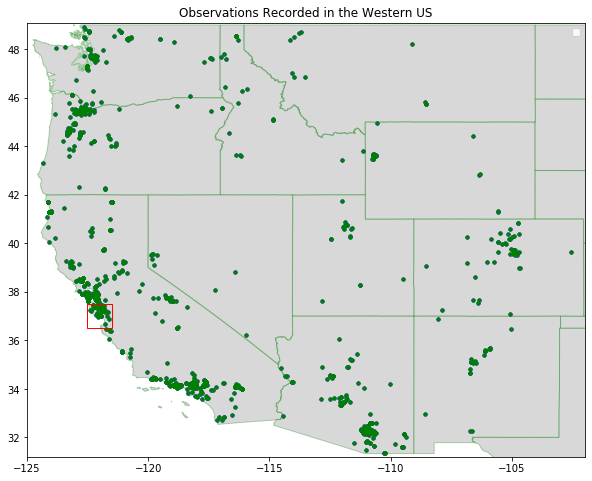

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
us.plot(ax=ax,alpha=0.3,color='grey',edgecolor='green')
geo_df.plot(ax=ax,markersize=10,color='blue')
geo_df.plot(ax=ax,markersize=10,color='green')
ax.set_xlim(-125,-102)
ax.set_ylim(31.2,49.1)
#ax.set_xlim(-123,-121)
#ax.set_ylim(36,39)
rect = patches.Rectangle((-122.5,36.5),1,1,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.title('Observations Recorded in the Western US')
plt.legend();

In [407]:
#data[data.Day_of_Year==30].groupby('Phenophase_Description').count().iloc[:,0].sort_values()
#pd.set_option("display.max_rows", 50, "display.max_columns", None)
print (data.query("Day_of_Year == 30 and Genus == 'Ribes'")[['Phenophase_Description','Phenophase_Status']])
#print (data[data.Individual_ID==37758].Phenophase_Description)

            Phenophase_Description  Phenophase_Status
716277          Breaking leaf buds                  0
716336                 Ripe fruits                  0
716396        Increasing leaf size                  1
716455              Falling leaves                  0
716574              Colored leaves                  0
716633      Flowers or flower buds                  1
716693                Open flowers                  1
716753   Recent fruit or seed drop                  0
716813                      Fruits                  0
2283614         Breaking leaf buds                  1
2283624                Ripe fruits                  0
2283635       Increasing leaf size                  1
2283646             Falling leaves                  0
2283672             Colored leaves                  0
2283686     Flowers or flower buds                  1
2283700               Open flowers                  1
2283713  Recent fruit or seed drop                  0
2283726                     

In [308]:
#print (data.query("Day_of_Year == 30").groupby('Genus').count())#[['Phenophase_Description','Phenophase_Status']])
#print (data.query("Day_of_Year == 30 and Genus == 'Sambucus'"))#[['Phenophase_Description','Phenophase_Status']])
data.query("Phenophase_Status == 1 and Phenophase_Description == 'Young leaves (tree/shrub)'").sample(5)
data.query("Submission_ID == 1019623 and ITIS_Number == 18956 and Observation_Date == '2016-07-12'")

,Observation_ID,Dataset_ID,ObservedBy_Person_ID,Submission_ID,SubmittedBy_Person_ID,Submission_Datetime,UpdatedBy_Person_ID,Update_Datetime,Partner_Group,Site_ID,Site_Name,Latitude,Longitude,Elevation_in_Meters,State,Species_ID,Genus,Species,Common_Name,Kingdom,Species_Functional_Type,Species_Category,USDA_PLANTS_Symbol,ITIS_Number,Individual_ID,Plant_Nickname,Patch,Protocol_ID,Phenophase_ID,Phenophase_Category,Phenophase_Description,Phenophase_Name,Phenophase_Definition_ID,Species-Specific_Info_ID,Observation_Date,Observation_Time,Day_of_Year,Phenophase_Status,Intensity_Category_ID,Intensity_Value,Abundance_Value,Site_Visit_ID,Observation_Comments,Observed_Status_Conflict_Flag,Status_Conflict_Related_Records,AGDD,AGDD_in_F,Tmax_Winter,Tmax_Spring,Tmax_Summer,Tmax_Fall,Tmax,Tmax_in_F,Tmin_Winter,Tmin_Spring,Tmin_Summer,Tmin_Fall,Tmin,Tmin_in_F,Prcp_Winter,Prcp_Spring,Prcp_Summer,Prcp_Fall,Prcp,Accum_Prcp,Daylength,date
668847,9192960,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,390,Fruits,Ripe fruits,Ripe fruits,390,5553,2016-07-12,00:00:00,194,1,58,Less than 5%,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-07-12
669026,9192955,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,482,Leaves,Initial growth (forbs),Initial growth,482,-9999,2016-07-12,00:00:00,194,0,-9999,-9999,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-07-12
669205,9192956,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,488,Leaves,Leaves (forbs),Leaves,488,-9999,2016-07-12,00:00:00,194,1,-9999,-9999,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-07-12
669384,9192957,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,500,Flowers,Flowers or flower buds,Flowers or flower buds,548,6638,2016-07-12,00:00:00,194,1,49,3 to 10,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-07-12
669563,9192958,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,501,Flowers,Open flowers,Open flowers,501,6895,2016-07-12,00:00:00,194,1,50,Less than 5%,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-07-12
669742,9192961,-9999,5325,1019623,5325,2016-10-31 19:31:43,5325,2016-10-31 19:44:07,-9999,8770,San Luis Obispo Botanical Garden,35.330288,-120.728859,84,CA,162,Eschscholzia,californica,California poppy,Plantae,Forb,-9999,ESCA2,18956,60933,California poppy-2,-9999,223,504,Fruits,Recent fruit or seed drop,Recent fruit or seed drop,504,7267,2016-07-12,00:00:00,194,-1,60,-9999,-9999,218363,-9999,-9999,'-9999',3058.25,5504.85,18.96,22.14,28.19,25.75,29.0,84.2,6.13,8.53,11.81,11.8,11.5,52.7,254,146,0,43,0,338,51149,2016-

### Plots

In [412]:
_data = data.query('Phenophase_Status==1')

def get_values(key,y=None):
    if (y==None):
        return pd.cut(_data[_data.Phenophase_Description.isin(key)].Day_of_Year,np.arange(367)).value_counts().sort_index().values
    else:
        return pd.cut(_data[(_data.Phenophase_Description.isin(key))&(_data.date.dt.year==y)].Day_of_Year,np.arange(367)).value_counts().sort_index().values

doy = np.arange(1,367,1)

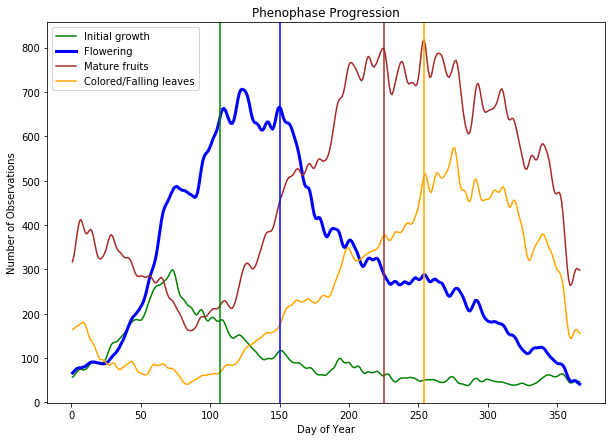

In [413]:
y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

plt.plot(doy,y_vals(get_values(['Breaking leaf buds','Incresing leaf size']),2.5),color='green',label="Initial growth")
plt.plot(doy,y_vals(get_values(['Open flowers','Flowers or flower buds']),2.5),linewidth=3,color='blue',label="Flowering")
plt.plot(doy,y_vals(get_values(['Fruits','Ripe fruits','Recent fruit or seed drop']),2.5),color='brown',label="Mature fruits")
plt.plot(doy,y_vals(get_values(['Colored leaves','Falling leaves']),2.5),color='orange',label="Colored/Falling leaves")

med_1 = _data[_data.Phenophase_Description.isin(['Breaking leaf buds','Incresing leaf size'])].Day_of_Year.quantile(0.5)
med_2 = _data[_data.Phenophase_Description.isin(['Open flowers','Flowers or flower buds'])].Day_of_Year.quantile(0.5)
med_3 = _data[_data.Phenophase_Description.isin(['Fruits','Ripe fruits','Recent fruit or seed drop'])].Day_of_Year.quantile(0.5)
med_4 = _data[_data.Phenophase_Description.isin(['Colored leaves','Falling leaves'])].Day_of_Year.quantile(0.5)

plt.axvline(x=med_1,color='green')
plt.axvline(x=med_2,color='blue')
plt.axvline(x=med_3,color='brown')
plt.axvline(x=med_4,color='orange')


plt.ylabel('Number of Observations')
plt.xlabel('Day of Year')
plt.title('Phenophase Progression')
plt.legend();

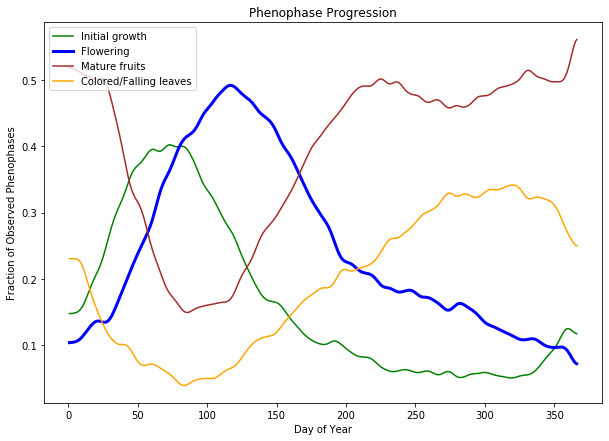

In [414]:
y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

total_yes_obs = get_values(['Breaking leaf buds','Increasing leaf size','Open flowers','Flowers or flower buds','Fruits','Ripe fruits','Recent fruit or seed drop','Colored leaves','Falling leaves'])

plt.plot(doy,y_vals(get_values(['Breaking leaf buds','Increasing leaf size'])/total_yes_obs,4),color='green',label="Initial growth")
plt.plot(doy,y_vals(get_values(['Open flowers','Flowers or flower buds'])/total_yes_obs,4),linewidth=3,color='blue',label="Flowering")
plt.plot(doy,y_vals(get_values(['Fruits','Ripe fruits','Recent fruit or seed drop'])/total_yes_obs,4),color='brown',label="Mature fruits")
plt.plot(doy,y_vals(get_values(['Colored leaves','Falling leaves'])/total_yes_obs,4),color='orange',label="Colored/Falling leaves")

med_1 = _data[_data.Phenophase_Description.isin(['Breaking leaf buds','Increasing leaf size'])].Day_of_Year.quantile(0.5)
med_2 = _data[_data.Phenophase_Description.isin(['Open flowers','Flowers or flower buds'])].Day_of_Year.quantile(0.5)
med_3 = _data[_data.Phenophase_Description.isin(['Fruits','Ripe fruits','Recent fruit or seed drop'])].Day_of_Year.quantile(0.5)
med_4 = _data[_data.Phenophase_Description.isin(['Colored leaves','Falling leaves'])].Day_of_Year.quantile(0.5)

plt.ylabel('Fraction of Observed Phenophases')
plt.xlabel('Day of Year')
plt.title('Phenophase Progression')
plt.legend();

In [63]:
_data = data.query('Phenophase_Status==0 or Phenophase_Status==1')

def get_values(key):
    l0 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==0').Day_of_Year,np.arange(367)).value_counts().sort_index().values
    l1 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==1').Day_of_Year,np.arange(367)).value_counts().sort_index().values
    return (l0,l1)
    
doy = np.arange(1,367,1)

y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

#total_yes_obs = get_values(['Breaking leaf buds','Increasing leaf size','Open flowers','Flowers or flower buds','Fruits','Ripe fruits','Recent fruit or seed drop','Colored leaves','Falling leaves'])

open_flowers_0, open_flowers_1 = get_values(['Open flowers'])
ffb_0, ffb_1 = get_values(['Flowers or flower buds'])
blb_0, blb_1 = get_values(['Breaking leaf buds'])
fruits_0, fruits_1 = get_values(['Fruits'])
cl_0, cl_1 = get_values(['Colored leaves'])

<Figure size 720x504 with 0 Axes>

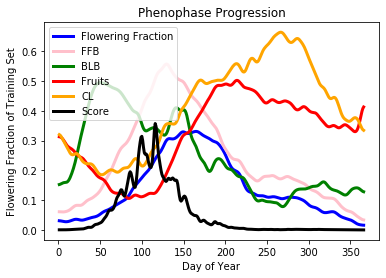

In [737]:
#plt.plot(doy,y_vals(open_flowers_1,4),color='green',label="Initial growth")
plt.plot(doy,y_vals(open_flowers_1/(open_flowers_1+open_flowers_0),4),linewidth=3,color='blue',label="Flowering Fraction")
plt.plot(doy,y_vals(ffb_1/(ffb_1+ffb_0),4),linewidth=3,color='pink',label="FFB")
plt.plot(doy,y_vals(blb_1/(blb_1+blb_0),4),linewidth=3,color='green',label="BLB")
plt.plot(doy,y_vals(fruits_1/(fruits_1+fruits_0),4),linewidth=3,color='red',label="Fruits")
plt.plot(doy,y_vals(cl_1/(cl_1+cl_0),4),linewidth=3,color='orange',label="CL")

p_of = open_flowers_1/(open_flowers_1+open_flowers_0)
p_ffb = ffb_1/(ffb_1+ffb_0)
p_blb = blb_1/(blb_1+blb_0)
p_fruits = fruits_1/(fruits_1+fruits_0)
p_cl = cl_1/(cl_1+cl_0)

plt.plot(doy,y_vals((p_ffb*p_blb*p_of)/(p_fruits*p_cl),2)/5.,linewidth=3,color='black',label='Score')

#plt.plot(doy,y_vals(open_flowers_0,4),linestyle=':',linewidth=3,color='blue',label="Not Flowering")
#plt.plot(doy,y_vals(get_values(['Fruits','Ripe fruits','Recent fruit or seed drop'])/total_yes_obs,4),color='brown',label="Mature fruits")
#plt.plot(doy,y_vals(get_values(['Colored leaves','Falling leaves'])/total_yes_obs,4),color='orange',label="Colored/Falling leaves")

#med_1 = _data[_data.Phenophase_Description.isin(['Breaking leaf buds','Increasing leaf size'])].Day_of_Year.quantile(0.5)
#med_2 = _data[_data.Phenophase_Description.isin(['Open flowers','Flowers or flower buds'])].Day_of_Year.quantile(0.5)
#med_3 = _data[_data.Phenophase_Description.isin(['Fruits','Ripe fruits','Recent fruit or seed drop'])].Day_of_Year.quantile(0.5)
#med_4 = _data[_data.Phenophase_Description.isin(['Colored leaves','Falling leaves'])].Day_of_Year.quantile(0.5)

plt.ylabel('Flowering Fraction of Training Set')
plt.xlabel('Day of Year')
plt.title('Phenophase Progression')
plt.legend();

/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


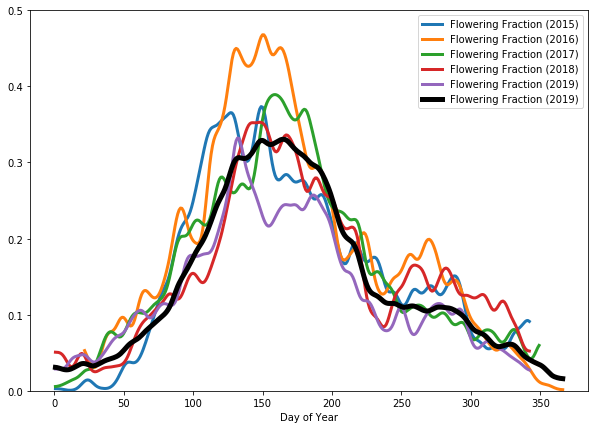

In [84]:
_data = data.query('Phenophase_Status==0 or Phenophase_Status==1')

def get_values(key,dates=' and 2008<date<2021'):
    l0 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==0'+dates).Day_of_Year,np.arange(367)).value_counts().sort_index().values
    l1 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==1'+dates).Day_of_Year,np.arange(367)).value_counts().sort_index().values
    return (l0,l1)
    
doy = np.arange(1,367,1)

y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

#total_yes_obs = get_values(['Breaking leaf buds','Increasing leaf size','Open flowers','Flowers or flower buds','Fruits','Ripe fruits','Recent fruit or seed drop','Colored leaves','Falling leaves'])

for yr in range(2015,2020):
    open_flowers_0, open_flowers_1 = get_values(['Open flowers'],dates=' and "%d-01-01"<=date<="%d-12-31"'%(yr,yr))
    plt.plot(doy,y_vals(open_flowers_1/(open_flowers_1+open_flowers_0),4),linewidth=3,label="Flowering Fraction (%d)"%yr)

open_flowers_0, open_flowers_1 = get_values(['Open flowers'])
plt.plot(doy,y_vals(open_flowers_1/(open_flowers_1+open_flowers_0),4),color='black',linewidth=5,label="Flowering Fraction (%d)"%yr)

#plt.ylabel('Flowering Fraction')# of Training Set')
plt.xlabel('Day of Year')
plt.ylim((0,0.5))
#plt.title('Phenophase Progression')
plt.legend();

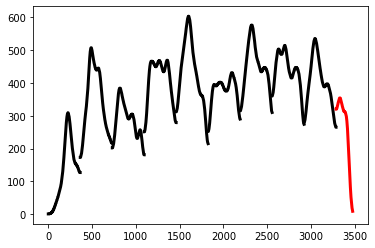

In [61]:
# plot number of observations over time in database
def get_values(key):
    l0 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==0').Day_of_Year,np.arange(367)).value_counts().sort_index().values
    l1 = pd.cut(_data[_data.Phenophase_Description.isin(key)].query('Phenophase_Status==1').Day_of_Year,np.arange(367)).value_counts().sort_index().values
    return (l0,l1)
   
#plt.figure(figsize=(10,7))
doy = np.arange(1,367,1)
y_vals=lambda x, std: gaussian_filter1d(x,std)

cum_day = 0
#x_data = np.zeros()
#y_data = []

for yr in range(2011,2021):
    last_day = date(yr,12,31).timetuple().tm_yday
    doy = np.arange(1,last_day+1,1)
    vals = pd.cut(data[data.date.dt.year==yr].Day_of_Year,np.arange(last_day+1)).value_counts().sort_index().values
    if (yr != 2020):
        plt.plot(doy+cum_day,y_vals(vals,20),linewidth=3,color='black')
        cum_day += last_day

plt.plot((doy+cum_day)[:190],y_vals(vals,20)[:190],linewidth=3,color='red')

        
#plt.plot(doy,y_vals((p_ffb*p_blb*p_of)/(p_fruits*p_cl),2)/5.,linewidth=3,color='black',label='Score')

    
#data.groupby([data["date"].dt.year, data["date"].dt.month]).count()

In [54]:
date(2008,1,1)
date(2008,1,1)+timedelta(days=500)

datetime.date(2009, 5, 15)

In [191]:
data.groupby(['Submission_ID','date','Individual_ID']).count().max()

Latitude                   18
Longitude                  18
Elevation_in_Meters        18
Genus                      18
Species                    18
Common_Name                18
Species_Functional_Type    18
Species_Category           18
Phenophase_ID              18
Phenophase_Category        18
Phenophase_Description     18
Phenophase_Name            18
Phenophase_Status          18
Observation_Date           18
Day_of_Year                18
Intensity_Value            18
AGDD                       18
Accum_Prcp                 18
Taxon                      18
AGDD0_100                  18
cum_ppt_100                18
dtype: int64

## Including Full AGDD data

In [143]:
#data = data[data.date>date(2016,4,15)]

In [391]:
class raster_dataset:
    
    def __init__(self, filename):#, window=None):
        #self.window = window
        self.src = rasterio.open(filename)
        self.src_coord = pyproj.Proj(self.src.crs)
        self.lonlat = pyproj.Proj(init='epsg:4326')
        self.data = self.src.read(1)#, window=self.window)

    def get_gps (self, row, col):
        east, north = self.src.xy(row,col) # image --> spatial coordinates
        lon,lat = pyproj.transform(self.src_coord, self.lonlat, east, north)
        value = self.data[row, col]
        return lon, lat
    
    # input: longitude, latitude (gps coordinate)
    # return: data value at input location(s)
    def get_value (self, lon, lat):
        east,north = pyproj.transform(self.lonlat, self.src_coord, lon, lat)
    
        # What is the corresponding row and column in our image?
        row, col = self.src.index(east, north) # spatial --> image coordinates
        #print(f'row,col=\t\t({row},{col})')
    
        # What is the value at that index?
        value = self.data[row, col]
        return value
    
    def get_rc (self, lon, lat):
        east,north = pyproj.transform(self.lonlat, self.src_coord, lon, lat)
        return self.src.index(east, north)
    
    def write_file (self, filename, data=None):
        
        if data is None:
            data = self.data
    
        with rasterio.Env():
        
            # Write an array as a raster band to a new 8-bit file. For
            # the new file's profile, we start with the profile of the source
            profile = self.src.profile
        
            # And then change the band count to 1, set the
            # dtype to uint8, and specify LZW compression.
            profile.update(
                dtype=rasterio.float32,
                count=1,
                compress='lzw')
        
            with rasterio.open(filename, 'w', **profile) as dst:
                dst.write(data.astype(rasterio.float32), 1)


In [168]:
# now we want to open up agdd files and look up values
# group dataframe by day
data['AGDD0_100'] = np.nan
groups = data.groupby('date')

In [169]:
# agdd0 file path
agdd_path = 'prism/daily/agdd0/%s/PRISM_agdd0_%s%02d%02d.tif'

count = 0
for key,group in groups:
        # read in aggd0 file
        agdd_data = raster_dataset(agdd_path % (key.year,key.year,key.month,key.day))
        #print (group)
        data.loc[group.index,'AGDD0_100'] = group.apply(lambda x: agdd_data.get_value(x.Longitude,x.Latitude), axis=1)
        count += 1
        print ('Iteration %d of %d' % (count,groups.ngroups))
        #if (count == 100):
        #       break
        
    

Iteration 1 of 3704
Iteration 2 of 3704
Iteration 3 of 3704
Iteration 4 of 3704
Iteration 5 of 3704
Iteration 6 of 3704
Iteration 7 of 3704
Iteration 8 of 3704
Iteration 9 of 3704
Iteration 10 of 3704
Iteration 11 of 3704
Iteration 12 of 3704
Iteration 13 of 3704
Iteration 14 of 3704
Iteration 15 of 3704
Iteration 16 of 3704
Iteration 17 of 3704
Iteration 18 of 3704
Iteration 19 of 3704
Iteration 20 of 3704
Iteration 21 of 3704
Iteration 22 of 3704
Iteration 23 of 3704
Iteration 24 of 3704
Iteration 25 of 3704
Iteration 26 of 3704
Iteration 27 of 3704
Iteration 28 of 3704
Iteration 29 of 3704
Iteration 30 of 3704
Iteration 31 of 3704
Iteration 32 of 3704
Iteration 33 of 3704
Iteration 34 of 3704
Iteration 35 of 3704
Iteration 36 of 3704
Iteration 37 of 3704
Iteration 38 of 3704
Iteration 39 of 3704
Iteration 40 of 3704
Iteration 41 of 3704
Iteration 42 of 3704
Iteration 43 of 3704
Iteration 44 of 3704
Iteration 45 of 3704
Iteration 46 of 3704
Iteration 47 of 3704
Iteration 48 of 3704
I

Iteration 380 of 3704
Iteration 381 of 3704
Iteration 382 of 3704
Iteration 383 of 3704
Iteration 384 of 3704
Iteration 385 of 3704
Iteration 386 of 3704
Iteration 387 of 3704
Iteration 388 of 3704
Iteration 389 of 3704
Iteration 390 of 3704
Iteration 391 of 3704
Iteration 392 of 3704
Iteration 393 of 3704
Iteration 394 of 3704
Iteration 395 of 3704
Iteration 396 of 3704
Iteration 397 of 3704
Iteration 398 of 3704
Iteration 399 of 3704
Iteration 400 of 3704
Iteration 401 of 3704
Iteration 402 of 3704
Iteration 403 of 3704
Iteration 404 of 3704
Iteration 405 of 3704
Iteration 406 of 3704
Iteration 407 of 3704
Iteration 408 of 3704
Iteration 409 of 3704
Iteration 410 of 3704
Iteration 411 of 3704
Iteration 412 of 3704
Iteration 413 of 3704
Iteration 414 of 3704
Iteration 415 of 3704
Iteration 416 of 3704
Iteration 417 of 3704
Iteration 418 of 3704
Iteration 419 of 3704
Iteration 420 of 3704
Iteration 421 of 3704
Iteration 422 of 3704
Iteration 423 of 3704
Iteration 424 of 3704
Iteration 

Iteration 755 of 3704
Iteration 756 of 3704
Iteration 757 of 3704
Iteration 758 of 3704
Iteration 759 of 3704
Iteration 760 of 3704
Iteration 761 of 3704
Iteration 762 of 3704
Iteration 763 of 3704
Iteration 764 of 3704
Iteration 765 of 3704
Iteration 766 of 3704
Iteration 767 of 3704
Iteration 768 of 3704
Iteration 769 of 3704
Iteration 770 of 3704
Iteration 771 of 3704
Iteration 772 of 3704
Iteration 773 of 3704
Iteration 774 of 3704
Iteration 775 of 3704
Iteration 776 of 3704
Iteration 777 of 3704
Iteration 778 of 3704
Iteration 779 of 3704
Iteration 780 of 3704
Iteration 781 of 3704
Iteration 782 of 3704
Iteration 783 of 3704
Iteration 784 of 3704
Iteration 785 of 3704
Iteration 786 of 3704
Iteration 787 of 3704
Iteration 788 of 3704
Iteration 789 of 3704
Iteration 790 of 3704
Iteration 791 of 3704
Iteration 792 of 3704
Iteration 793 of 3704
Iteration 794 of 3704
Iteration 795 of 3704
Iteration 796 of 3704
Iteration 797 of 3704
Iteration 798 of 3704
Iteration 799 of 3704
Iteration 

Iteration 1123 of 3704
Iteration 1124 of 3704
Iteration 1125 of 3704
Iteration 1126 of 3704
Iteration 1127 of 3704
Iteration 1128 of 3704
Iteration 1129 of 3704
Iteration 1130 of 3704
Iteration 1131 of 3704
Iteration 1132 of 3704
Iteration 1133 of 3704
Iteration 1134 of 3704
Iteration 1135 of 3704
Iteration 1136 of 3704
Iteration 1137 of 3704
Iteration 1138 of 3704
Iteration 1139 of 3704
Iteration 1140 of 3704
Iteration 1141 of 3704
Iteration 1142 of 3704
Iteration 1143 of 3704
Iteration 1144 of 3704
Iteration 1145 of 3704
Iteration 1146 of 3704
Iteration 1147 of 3704
Iteration 1148 of 3704
Iteration 1149 of 3704
Iteration 1150 of 3704
Iteration 1151 of 3704
Iteration 1152 of 3704
Iteration 1153 of 3704
Iteration 1154 of 3704
Iteration 1155 of 3704
Iteration 1156 of 3704
Iteration 1157 of 3704
Iteration 1158 of 3704
Iteration 1159 of 3704
Iteration 1160 of 3704
Iteration 1161 of 3704
Iteration 1162 of 3704
Iteration 1163 of 3704
Iteration 1164 of 3704
Iteration 1165 of 3704
Iteration 1

Iteration 1480 of 3704
Iteration 1481 of 3704
Iteration 1482 of 3704
Iteration 1483 of 3704
Iteration 1484 of 3704
Iteration 1485 of 3704
Iteration 1486 of 3704
Iteration 1487 of 3704
Iteration 1488 of 3704
Iteration 1489 of 3704
Iteration 1490 of 3704
Iteration 1491 of 3704
Iteration 1492 of 3704
Iteration 1493 of 3704
Iteration 1494 of 3704
Iteration 1495 of 3704
Iteration 1496 of 3704
Iteration 1497 of 3704
Iteration 1498 of 3704
Iteration 1499 of 3704
Iteration 1500 of 3704
Iteration 1501 of 3704
Iteration 1502 of 3704
Iteration 1503 of 3704
Iteration 1504 of 3704
Iteration 1505 of 3704
Iteration 1506 of 3704
Iteration 1507 of 3704
Iteration 1508 of 3704
Iteration 1509 of 3704
Iteration 1510 of 3704
Iteration 1511 of 3704
Iteration 1512 of 3704
Iteration 1513 of 3704
Iteration 1514 of 3704
Iteration 1515 of 3704
Iteration 1516 of 3704
Iteration 1517 of 3704
Iteration 1518 of 3704
Iteration 1519 of 3704
Iteration 1520 of 3704
Iteration 1521 of 3704
Iteration 1522 of 3704
Iteration 1

Iteration 1837 of 3704
Iteration 1838 of 3704
Iteration 1839 of 3704
Iteration 1840 of 3704
Iteration 1841 of 3704
Iteration 1842 of 3704
Iteration 1843 of 3704
Iteration 1844 of 3704
Iteration 1845 of 3704
Iteration 1846 of 3704
Iteration 1847 of 3704
Iteration 1848 of 3704
Iteration 1849 of 3704
Iteration 1850 of 3704
Iteration 1851 of 3704
Iteration 1852 of 3704
Iteration 1853 of 3704
Iteration 1854 of 3704
Iteration 1855 of 3704
Iteration 1856 of 3704
Iteration 1857 of 3704
Iteration 1858 of 3704
Iteration 1859 of 3704
Iteration 1860 of 3704
Iteration 1861 of 3704
Iteration 1862 of 3704
Iteration 1863 of 3704
Iteration 1864 of 3704
Iteration 1865 of 3704
Iteration 1866 of 3704
Iteration 1867 of 3704
Iteration 1868 of 3704
Iteration 1869 of 3704
Iteration 1870 of 3704
Iteration 1871 of 3704
Iteration 1872 of 3704
Iteration 1873 of 3704
Iteration 1874 of 3704
Iteration 1875 of 3704
Iteration 1876 of 3704
Iteration 1877 of 3704
Iteration 1878 of 3704
Iteration 1879 of 3704
Iteration 1

Iteration 2194 of 3704
Iteration 2195 of 3704
Iteration 2196 of 3704
Iteration 2197 of 3704
Iteration 2198 of 3704
Iteration 2199 of 3704
Iteration 2200 of 3704
Iteration 2201 of 3704
Iteration 2202 of 3704
Iteration 2203 of 3704
Iteration 2204 of 3704
Iteration 2205 of 3704
Iteration 2206 of 3704
Iteration 2207 of 3704
Iteration 2208 of 3704
Iteration 2209 of 3704
Iteration 2210 of 3704
Iteration 2211 of 3704
Iteration 2212 of 3704
Iteration 2213 of 3704
Iteration 2214 of 3704
Iteration 2215 of 3704
Iteration 2216 of 3704
Iteration 2217 of 3704
Iteration 2218 of 3704
Iteration 2219 of 3704
Iteration 2220 of 3704
Iteration 2221 of 3704
Iteration 2222 of 3704
Iteration 2223 of 3704
Iteration 2224 of 3704
Iteration 2225 of 3704
Iteration 2226 of 3704
Iteration 2227 of 3704
Iteration 2228 of 3704
Iteration 2229 of 3704
Iteration 2230 of 3704
Iteration 2231 of 3704
Iteration 2232 of 3704
Iteration 2233 of 3704
Iteration 2234 of 3704
Iteration 2235 of 3704
Iteration 2236 of 3704
Iteration 2

Iteration 2554 of 3704
Iteration 2555 of 3704
Iteration 2556 of 3704
Iteration 2557 of 3704
Iteration 2558 of 3704
Iteration 2559 of 3704
Iteration 2560 of 3704
Iteration 2561 of 3704
Iteration 2562 of 3704
Iteration 2563 of 3704
Iteration 2564 of 3704
Iteration 2565 of 3704
Iteration 2566 of 3704
Iteration 2567 of 3704
Iteration 2568 of 3704
Iteration 2569 of 3704
Iteration 2570 of 3704
Iteration 2571 of 3704
Iteration 2572 of 3704
Iteration 2573 of 3704
Iteration 2574 of 3704
Iteration 2575 of 3704
Iteration 2576 of 3704
Iteration 2577 of 3704
Iteration 2578 of 3704
Iteration 2579 of 3704
Iteration 2580 of 3704
Iteration 2581 of 3704
Iteration 2582 of 3704
Iteration 2583 of 3704
Iteration 2584 of 3704
Iteration 2585 of 3704
Iteration 2586 of 3704
Iteration 2587 of 3704
Iteration 2588 of 3704
Iteration 2589 of 3704
Iteration 2590 of 3704
Iteration 2591 of 3704
Iteration 2592 of 3704
Iteration 2593 of 3704
Iteration 2594 of 3704
Iteration 2595 of 3704
Iteration 2596 of 3704
Iteration 2

Iteration 2911 of 3704
Iteration 2912 of 3704
Iteration 2913 of 3704
Iteration 2914 of 3704
Iteration 2915 of 3704
Iteration 2916 of 3704
Iteration 2917 of 3704
Iteration 2918 of 3704
Iteration 2919 of 3704
Iteration 2920 of 3704
Iteration 2921 of 3704
Iteration 2922 of 3704
Iteration 2923 of 3704
Iteration 2924 of 3704
Iteration 2925 of 3704
Iteration 2926 of 3704
Iteration 2927 of 3704
Iteration 2928 of 3704
Iteration 2929 of 3704
Iteration 2930 of 3704
Iteration 2931 of 3704
Iteration 2932 of 3704
Iteration 2933 of 3704
Iteration 2934 of 3704
Iteration 2935 of 3704
Iteration 2936 of 3704
Iteration 2937 of 3704
Iteration 2938 of 3704
Iteration 2939 of 3704
Iteration 2940 of 3704
Iteration 2941 of 3704
Iteration 2942 of 3704
Iteration 2943 of 3704
Iteration 2944 of 3704
Iteration 2945 of 3704
Iteration 2946 of 3704
Iteration 2947 of 3704
Iteration 2948 of 3704
Iteration 2949 of 3704
Iteration 2950 of 3704
Iteration 2951 of 3704
Iteration 2952 of 3704
Iteration 2953 of 3704
Iteration 2

Iteration 3268 of 3704
Iteration 3269 of 3704
Iteration 3270 of 3704
Iteration 3271 of 3704
Iteration 3272 of 3704
Iteration 3273 of 3704
Iteration 3274 of 3704
Iteration 3275 of 3704
Iteration 3276 of 3704
Iteration 3277 of 3704
Iteration 3278 of 3704
Iteration 3279 of 3704
Iteration 3280 of 3704
Iteration 3281 of 3704
Iteration 3282 of 3704
Iteration 3283 of 3704
Iteration 3284 of 3704
Iteration 3285 of 3704
Iteration 3286 of 3704
Iteration 3287 of 3704
Iteration 3288 of 3704
Iteration 3289 of 3704
Iteration 3290 of 3704
Iteration 3291 of 3704
Iteration 3292 of 3704
Iteration 3293 of 3704
Iteration 3294 of 3704
Iteration 3295 of 3704
Iteration 3296 of 3704
Iteration 3297 of 3704
Iteration 3298 of 3704
Iteration 3299 of 3704
Iteration 3300 of 3704
Iteration 3301 of 3704
Iteration 3302 of 3704
Iteration 3303 of 3704
Iteration 3304 of 3704
Iteration 3305 of 3704
Iteration 3306 of 3704
Iteration 3307 of 3704
Iteration 3308 of 3704
Iteration 3309 of 3704
Iteration 3310 of 3704
Iteration 3

Iteration 3627 of 3704
Iteration 3628 of 3704
Iteration 3629 of 3704
Iteration 3630 of 3704
Iteration 3631 of 3704
Iteration 3632 of 3704
Iteration 3633 of 3704
Iteration 3634 of 3704
Iteration 3635 of 3704
Iteration 3636 of 3704
Iteration 3637 of 3704
Iteration 3638 of 3704
Iteration 3639 of 3704
Iteration 3640 of 3704
Iteration 3641 of 3704
Iteration 3642 of 3704
Iteration 3643 of 3704
Iteration 3644 of 3704
Iteration 3645 of 3704
Iteration 3646 of 3704
Iteration 3647 of 3704
Iteration 3648 of 3704
Iteration 3649 of 3704
Iteration 3650 of 3704
Iteration 3651 of 3704
Iteration 3652 of 3704
Iteration 3653 of 3704
Iteration 3654 of 3704
Iteration 3655 of 3704
Iteration 3656 of 3704
Iteration 3657 of 3704
Iteration 3658 of 3704
Iteration 3659 of 3704
Iteration 3660 of 3704
Iteration 3661 of 3704
Iteration 3662 of 3704
Iteration 3663 of 3704
Iteration 3664 of 3704
Iteration 3665 of 3704
Iteration 3666 of 3704
Iteration 3667 of 3704
Iteration 3668 of 3704
Iteration 3669 of 3704
Iteration 3

In [146]:
# save data with AGDD values
#data.to_pickle('npn_dataset_agdd.pkl')
#data = pd.read_pickle('npn_dataset_agdd.pkl')


In [170]:
data.query('AGDD0_100 > -1000').AGDD0_100.quantile([0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
#data.query('AGDD0_100 < 1 and AGDD0_100 > -1000').describe()

0.001    -416.045013
0.100     751.310059
0.200    1044.129028
0.300    1222.419067
0.400    1374.376099
0.500    1519.140015
0.600    1682.288696
0.700    1875.703125
0.800    2103.025146
0.900    2456.160156
0.990    3081.595215
Name: AGDD0_100, dtype: float64

### Including full PPT data

In [171]:
# now we want to open up agdd files and look up values
# group dataframe by day
data['cum_ppt_100'] = np.nan
groups = data.groupby('date')

In [172]:
# cum_ppt_100 file path
cum_ppt_path = 'prism/daily/cum_ppt_100/%s/PRISM_cum_ppt_100_%s%02d%02d.tif'

count = 0
for key,group in groups:
        # read in cum_ppt file
        cum_ppt_data = raster_dataset(cum_ppt_path % (key.year,key.year,key.month,key.day))
        #print (group)
        data.loc[group.index,'cum_ppt_100'] = group.apply(lambda x: cum_ppt_data.get_value(x.Longitude,x.Latitude), axis=1)
        count += 1
        print ('Iteration %d of %d' % (count,groups.ngroups))
        #if (count == 100):
        #       break
        
    

Iteration 1 of 3704
Iteration 2 of 3704
Iteration 3 of 3704
Iteration 4 of 3704
Iteration 5 of 3704
Iteration 6 of 3704
Iteration 7 of 3704
Iteration 8 of 3704
Iteration 9 of 3704
Iteration 10 of 3704
Iteration 11 of 3704
Iteration 12 of 3704
Iteration 13 of 3704
Iteration 14 of 3704
Iteration 15 of 3704
Iteration 16 of 3704
Iteration 17 of 3704
Iteration 18 of 3704
Iteration 19 of 3704
Iteration 20 of 3704
Iteration 21 of 3704
Iteration 22 of 3704
Iteration 23 of 3704
Iteration 24 of 3704
Iteration 25 of 3704
Iteration 26 of 3704
Iteration 27 of 3704
Iteration 28 of 3704
Iteration 29 of 3704
Iteration 30 of 3704
Iteration 31 of 3704
Iteration 32 of 3704
Iteration 33 of 3704
Iteration 34 of 3704
Iteration 35 of 3704
Iteration 36 of 3704
Iteration 37 of 3704
Iteration 38 of 3704
Iteration 39 of 3704
Iteration 40 of 3704
Iteration 41 of 3704
Iteration 42 of 3704
Iteration 43 of 3704
Iteration 44 of 3704
Iteration 45 of 3704
Iteration 46 of 3704
Iteration 47 of 3704
Iteration 48 of 3704
I

Iteration 380 of 3704
Iteration 381 of 3704
Iteration 382 of 3704
Iteration 383 of 3704
Iteration 384 of 3704
Iteration 385 of 3704
Iteration 386 of 3704
Iteration 387 of 3704
Iteration 388 of 3704
Iteration 389 of 3704
Iteration 390 of 3704
Iteration 391 of 3704
Iteration 392 of 3704
Iteration 393 of 3704
Iteration 394 of 3704
Iteration 395 of 3704
Iteration 396 of 3704
Iteration 397 of 3704
Iteration 398 of 3704
Iteration 399 of 3704
Iteration 400 of 3704
Iteration 401 of 3704
Iteration 402 of 3704
Iteration 403 of 3704
Iteration 404 of 3704
Iteration 405 of 3704
Iteration 406 of 3704
Iteration 407 of 3704
Iteration 408 of 3704
Iteration 409 of 3704
Iteration 410 of 3704
Iteration 411 of 3704
Iteration 412 of 3704
Iteration 413 of 3704
Iteration 414 of 3704
Iteration 415 of 3704
Iteration 416 of 3704
Iteration 417 of 3704
Iteration 418 of 3704
Iteration 419 of 3704
Iteration 420 of 3704
Iteration 421 of 3704
Iteration 422 of 3704
Iteration 423 of 3704
Iteration 424 of 3704
Iteration 

Iteration 753 of 3704
Iteration 754 of 3704
Iteration 755 of 3704
Iteration 756 of 3704
Iteration 757 of 3704
Iteration 758 of 3704
Iteration 759 of 3704
Iteration 760 of 3704
Iteration 761 of 3704
Iteration 762 of 3704
Iteration 763 of 3704
Iteration 764 of 3704
Iteration 765 of 3704
Iteration 766 of 3704
Iteration 767 of 3704
Iteration 768 of 3704
Iteration 769 of 3704
Iteration 770 of 3704
Iteration 771 of 3704
Iteration 772 of 3704
Iteration 773 of 3704
Iteration 774 of 3704
Iteration 775 of 3704
Iteration 776 of 3704
Iteration 777 of 3704
Iteration 778 of 3704
Iteration 779 of 3704
Iteration 780 of 3704
Iteration 781 of 3704
Iteration 782 of 3704
Iteration 783 of 3704
Iteration 784 of 3704
Iteration 785 of 3704
Iteration 786 of 3704
Iteration 787 of 3704
Iteration 788 of 3704
Iteration 789 of 3704
Iteration 790 of 3704
Iteration 791 of 3704
Iteration 792 of 3704
Iteration 793 of 3704
Iteration 794 of 3704
Iteration 795 of 3704
Iteration 796 of 3704
Iteration 797 of 3704
Iteration 

Iteration 1121 of 3704
Iteration 1122 of 3704
Iteration 1123 of 3704
Iteration 1124 of 3704
Iteration 1125 of 3704
Iteration 1126 of 3704
Iteration 1127 of 3704
Iteration 1128 of 3704
Iteration 1129 of 3704
Iteration 1130 of 3704
Iteration 1131 of 3704
Iteration 1132 of 3704
Iteration 1133 of 3704
Iteration 1134 of 3704
Iteration 1135 of 3704
Iteration 1136 of 3704
Iteration 1137 of 3704
Iteration 1138 of 3704
Iteration 1139 of 3704
Iteration 1140 of 3704
Iteration 1141 of 3704
Iteration 1142 of 3704
Iteration 1143 of 3704
Iteration 1144 of 3704
Iteration 1145 of 3704
Iteration 1146 of 3704
Iteration 1147 of 3704
Iteration 1148 of 3704
Iteration 1149 of 3704
Iteration 1150 of 3704
Iteration 1151 of 3704
Iteration 1152 of 3704
Iteration 1153 of 3704
Iteration 1154 of 3704
Iteration 1155 of 3704
Iteration 1156 of 3704
Iteration 1157 of 3704
Iteration 1158 of 3704
Iteration 1159 of 3704
Iteration 1160 of 3704
Iteration 1161 of 3704
Iteration 1162 of 3704
Iteration 1163 of 3704
Iteration 1

Iteration 1480 of 3704
Iteration 1481 of 3704
Iteration 1482 of 3704
Iteration 1483 of 3704
Iteration 1484 of 3704
Iteration 1485 of 3704
Iteration 1486 of 3704
Iteration 1487 of 3704
Iteration 1488 of 3704
Iteration 1489 of 3704
Iteration 1490 of 3704
Iteration 1491 of 3704
Iteration 1492 of 3704
Iteration 1493 of 3704
Iteration 1494 of 3704
Iteration 1495 of 3704
Iteration 1496 of 3704
Iteration 1497 of 3704
Iteration 1498 of 3704
Iteration 1499 of 3704
Iteration 1500 of 3704
Iteration 1501 of 3704
Iteration 1502 of 3704
Iteration 1503 of 3704
Iteration 1504 of 3704
Iteration 1505 of 3704
Iteration 1506 of 3704
Iteration 1507 of 3704
Iteration 1508 of 3704
Iteration 1509 of 3704
Iteration 1510 of 3704
Iteration 1511 of 3704
Iteration 1512 of 3704
Iteration 1513 of 3704
Iteration 1514 of 3704
Iteration 1515 of 3704
Iteration 1516 of 3704
Iteration 1517 of 3704
Iteration 1518 of 3704
Iteration 1519 of 3704
Iteration 1520 of 3704
Iteration 1521 of 3704
Iteration 1522 of 3704
Iteration 1

Iteration 1838 of 3704
Iteration 1839 of 3704
Iteration 1840 of 3704
Iteration 1841 of 3704
Iteration 1842 of 3704
Iteration 1843 of 3704
Iteration 1844 of 3704
Iteration 1845 of 3704
Iteration 1846 of 3704
Iteration 1847 of 3704
Iteration 1848 of 3704
Iteration 1849 of 3704
Iteration 1850 of 3704
Iteration 1851 of 3704
Iteration 1852 of 3704
Iteration 1853 of 3704
Iteration 1854 of 3704
Iteration 1855 of 3704
Iteration 1856 of 3704
Iteration 1857 of 3704
Iteration 1858 of 3704
Iteration 1859 of 3704
Iteration 1860 of 3704
Iteration 1861 of 3704
Iteration 1862 of 3704
Iteration 1863 of 3704
Iteration 1864 of 3704
Iteration 1865 of 3704
Iteration 1866 of 3704
Iteration 1867 of 3704
Iteration 1868 of 3704
Iteration 1869 of 3704
Iteration 1870 of 3704
Iteration 1871 of 3704
Iteration 1872 of 3704
Iteration 1873 of 3704
Iteration 1874 of 3704
Iteration 1875 of 3704
Iteration 1876 of 3704
Iteration 1877 of 3704
Iteration 1878 of 3704
Iteration 1879 of 3704
Iteration 1880 of 3704
Iteration 1

Iteration 2198 of 3704
Iteration 2199 of 3704
Iteration 2200 of 3704
Iteration 2201 of 3704
Iteration 2202 of 3704
Iteration 2203 of 3704
Iteration 2204 of 3704
Iteration 2205 of 3704
Iteration 2206 of 3704
Iteration 2207 of 3704
Iteration 2208 of 3704
Iteration 2209 of 3704
Iteration 2210 of 3704
Iteration 2211 of 3704
Iteration 2212 of 3704
Iteration 2213 of 3704
Iteration 2214 of 3704
Iteration 2215 of 3704
Iteration 2216 of 3704
Iteration 2217 of 3704
Iteration 2218 of 3704
Iteration 2219 of 3704
Iteration 2220 of 3704
Iteration 2221 of 3704
Iteration 2222 of 3704
Iteration 2223 of 3704
Iteration 2224 of 3704
Iteration 2225 of 3704
Iteration 2226 of 3704
Iteration 2227 of 3704
Iteration 2228 of 3704
Iteration 2229 of 3704
Iteration 2230 of 3704
Iteration 2231 of 3704
Iteration 2232 of 3704
Iteration 2233 of 3704
Iteration 2234 of 3704
Iteration 2235 of 3704
Iteration 2236 of 3704
Iteration 2237 of 3704
Iteration 2238 of 3704
Iteration 2239 of 3704
Iteration 2240 of 3704
Iteration 2

Iteration 2557 of 3704
Iteration 2558 of 3704
Iteration 2559 of 3704
Iteration 2560 of 3704
Iteration 2561 of 3704
Iteration 2562 of 3704
Iteration 2563 of 3704
Iteration 2564 of 3704
Iteration 2565 of 3704
Iteration 2566 of 3704
Iteration 2567 of 3704
Iteration 2568 of 3704
Iteration 2569 of 3704
Iteration 2570 of 3704
Iteration 2571 of 3704
Iteration 2572 of 3704
Iteration 2573 of 3704
Iteration 2574 of 3704
Iteration 2575 of 3704
Iteration 2576 of 3704
Iteration 2577 of 3704
Iteration 2578 of 3704
Iteration 2579 of 3704
Iteration 2580 of 3704
Iteration 2581 of 3704
Iteration 2582 of 3704
Iteration 2583 of 3704
Iteration 2584 of 3704
Iteration 2585 of 3704
Iteration 2586 of 3704
Iteration 2587 of 3704
Iteration 2588 of 3704
Iteration 2589 of 3704
Iteration 2590 of 3704
Iteration 2591 of 3704
Iteration 2592 of 3704
Iteration 2593 of 3704
Iteration 2594 of 3704
Iteration 2595 of 3704
Iteration 2596 of 3704
Iteration 2597 of 3704
Iteration 2598 of 3704
Iteration 2599 of 3704
Iteration 2

Iteration 2916 of 3704
Iteration 2917 of 3704
Iteration 2918 of 3704
Iteration 2919 of 3704
Iteration 2920 of 3704
Iteration 2921 of 3704
Iteration 2922 of 3704
Iteration 2923 of 3704
Iteration 2924 of 3704
Iteration 2925 of 3704
Iteration 2926 of 3704
Iteration 2927 of 3704
Iteration 2928 of 3704
Iteration 2929 of 3704
Iteration 2930 of 3704
Iteration 2931 of 3704
Iteration 2932 of 3704
Iteration 2933 of 3704
Iteration 2934 of 3704
Iteration 2935 of 3704
Iteration 2936 of 3704
Iteration 2937 of 3704
Iteration 2938 of 3704
Iteration 2939 of 3704
Iteration 2940 of 3704
Iteration 2941 of 3704
Iteration 2942 of 3704
Iteration 2943 of 3704
Iteration 2944 of 3704
Iteration 2945 of 3704
Iteration 2946 of 3704
Iteration 2947 of 3704
Iteration 2948 of 3704
Iteration 2949 of 3704
Iteration 2950 of 3704
Iteration 2951 of 3704
Iteration 2952 of 3704
Iteration 2953 of 3704
Iteration 2954 of 3704
Iteration 2955 of 3704
Iteration 2956 of 3704
Iteration 2957 of 3704
Iteration 2958 of 3704
Iteration 2

Iteration 3276 of 3704
Iteration 3277 of 3704
Iteration 3278 of 3704
Iteration 3279 of 3704
Iteration 3280 of 3704
Iteration 3281 of 3704
Iteration 3282 of 3704
Iteration 3283 of 3704
Iteration 3284 of 3704
Iteration 3285 of 3704
Iteration 3286 of 3704
Iteration 3287 of 3704
Iteration 3288 of 3704
Iteration 3289 of 3704
Iteration 3290 of 3704
Iteration 3291 of 3704
Iteration 3292 of 3704
Iteration 3293 of 3704
Iteration 3294 of 3704
Iteration 3295 of 3704
Iteration 3296 of 3704
Iteration 3297 of 3704
Iteration 3298 of 3704
Iteration 3299 of 3704
Iteration 3300 of 3704
Iteration 3301 of 3704
Iteration 3302 of 3704
Iteration 3303 of 3704
Iteration 3304 of 3704
Iteration 3305 of 3704
Iteration 3306 of 3704
Iteration 3307 of 3704
Iteration 3308 of 3704
Iteration 3309 of 3704
Iteration 3310 of 3704
Iteration 3311 of 3704
Iteration 3312 of 3704
Iteration 3313 of 3704
Iteration 3314 of 3704
Iteration 3315 of 3704
Iteration 3316 of 3704
Iteration 3317 of 3704
Iteration 3318 of 3704
Iteration 3

Iteration 3633 of 3704
Iteration 3634 of 3704
Iteration 3635 of 3704
Iteration 3636 of 3704
Iteration 3637 of 3704
Iteration 3638 of 3704
Iteration 3639 of 3704
Iteration 3640 of 3704
Iteration 3641 of 3704
Iteration 3642 of 3704
Iteration 3643 of 3704
Iteration 3644 of 3704
Iteration 3645 of 3704
Iteration 3646 of 3704
Iteration 3647 of 3704
Iteration 3648 of 3704
Iteration 3649 of 3704
Iteration 3650 of 3704
Iteration 3651 of 3704
Iteration 3652 of 3704
Iteration 3653 of 3704
Iteration 3654 of 3704
Iteration 3655 of 3704
Iteration 3656 of 3704
Iteration 3657 of 3704
Iteration 3658 of 3704
Iteration 3659 of 3704
Iteration 3660 of 3704
Iteration 3661 of 3704
Iteration 3662 of 3704
Iteration 3663 of 3704
Iteration 3664 of 3704
Iteration 3665 of 3704
Iteration 3666 of 3704
Iteration 3667 of 3704
Iteration 3668 of 3704
Iteration 3669 of 3704
Iteration 3670 of 3704
Iteration 3671 of 3704
Iteration 3672 of 3704
Iteration 3673 of 3704
Iteration 3674 of 3704
Iteration 3675 of 3704
Iteration 3

In [ ]:
#data.cum_ppt_100.quantile([0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

# convert Day of Year to daylength
data['daylength'] = data.apply(lambda x: daylength(x.Day_of_Year,x.Latitude),axis=1)

In [ ]:
# including state column in trimmed df
data1 = pd.read_csv('status_intensity_observation_data.csv', low_memory=False)
data2 = pd.read_csv('npn_2009-2014/status_intensity_observation_data.csv', low_memory=False)
data3 = pd.read_csv('npn-west_states/status_intensity_observation_data.csv', low_memory=False)

data_full = pd.concat([data1,data2,data3],ignore_index=True)

del data1
del data2
del data3

In [687]:
data['State'] = data_full.loc[data.index].State

In [3]:
#data.to_pickle('npn_dataset_agdd_ppt.pkl')
data = pd.read_pickle('npn_dataset_agdd_ppt.pkl')

## Model Training

Now I really need to dig into how to set up this dataset.

What types of plots will be useful as diagnosis?

For model training:  try normalizing continuous variables (elevation, doy, ppt, agdd).

For categorical, try 

In [227]:
def prepare_training_data (data, phenophase='Flowers or flower buds'):

    # Now, we want to be able to quantify seasonal progression from a single metric.
    train = data[['Individual_ID','date','State','Genus','Longitude','Latitude','Elevation_in_Meters','Phenophase_Description','Phenophase_Status','Day_of_Year','daylength','AGDD0_100','cum_ppt_100']].copy(deep=True)
    
    # we'll also get rid of -1 statuses, since these aren't very helpful for modeling
    train = train[train.Phenophase_Status!=-1]
    
    # drop a few null rows (missing elevation data)
    train = train[train.notnull().all(axis=1)]
    
    # select only open flowers:
    #train = train[train.Phenophase_Description=='Open flowers']
    train = train[train.Phenophase_Description==phenophase]
    
    print ("Training set total size: %d"%len(train))
    
    # split data into training / test set.
    # use one or more location holdouts for testing, as well as time holdout.
    
    # subsample dataframe to reduce number of repeated observations from each individual species
    train = train.sample(frac=1).groupby(['Individual_ID','Phenophase_Description']).head(10)
    
    # select only genera with at least 10 observations
    species_counts = train.groupby('Genus').count().iloc[:,0]
    species_counts.quantile([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
    train = train[train.Genus.isin(species_counts[species_counts>=10].index)]
    print ("Total number of species before trimming: %d"%len(species_counts))
    print ("Total number of species after trimming: %d"%len(train.groupby('Genus').count().iloc[:,0]))
    
    print ("Training set size after trimming: %d"%len(train))
    
    drop_cols = ['Individual_ID','date','State','Genus','Longitude','Latitude','Phenophase_Description','Phenophase_Status','Day_of_Year']
    
    # time holdout (test set #1)
    x_test_time = train[train.date>'2019-12-31'].copy(deep=True)
    y_test_time = x_test_time['Phenophase_Status']
    x_test_time_doy = x_test_time['Day_of_Year']
    x_test_time.drop(drop_cols, axis=1, inplace=True)
    train = train[train.date<='2019-12-31']
    
    # location holdout (test set #2)
    x_test_location = train.query('36.5 < Latitude < 37.5 and -122.5 < Longitude < -121.5').copy(deep=True)
    y_test_location = x_test_location['Phenophase_Status']
    x_test_location_doy = x_test_location['Day_of_Year']
    x_test_location.drop(drop_cols, axis=1, inplace=True)
    train = train[~train.isin(x_test_location).all(axis=1)]
    
    # prepare training data
    x_train = train.copy(deep=True)
    y_train = x_train['Phenophase_Status']
    x_train.drop(drop_cols,axis=1,inplace=True)
    
    return train, x_train, y_train, x_test_location, x_test_location_doy, y_test_location, x_test_time, x_test_time_doy, y_test_time

In [228]:
train, x_train, y_train, x_test_location, x_test_location_doy, y_test_location, x_test_time, x_test_time_doy, y_test_time = prepare_training_data(data,phenophase='Open flowers')

Training set total size: 235263
Total number of species before trimming: 163
Total number of species after trimming: 106
Training set size after trimming: 28449


In [65]:
# train 3 separate models, one for initial growth, one for flowering, one for mature growth
#x_train, x_test, y_train, y_test = train_test_split(train[train.Phenophase_Description=='Open flowers'].drop(['Genus','Longitude','Latitude','Phenophase_Description','Phenophase_Status'],axis=1),train[train.Phenophase_Description=='Open flowers'].Phenophase_Status,test_size=0.3)
#x_train, x_test, y_train, y_test = train_test_split(train[train.Phenophase_Description.isin(flowers)].drop(['Genus','Longitude','Latitude','Phenophase_Description','Phenophase_Status'],axis=1),train[train.Phenophase_Description.isin(flowers)].Phenophase_Status,test_size=0.3)

In [435]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha = 4
lasso_iter = 100000

# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 4

for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(x_train,y_train)
    test_pred = np.array(model.predict(x_test_time))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test_time)))
    print (RMSE)
    test_score = model.score(x_test_time,y_test_time)
    print (test_score)
    

16.041738217891023
0.07679874233991169
16.027571505831666
0.07842860952733888


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.8391224489974, tolerance: 0.3668052837209345
  tol, rng, random, positive)
/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.6799663851475, tolerance: 0.36158139534883393
  tol, rng, random, positive)
/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.69679266918047, tolerance: 0.3498353302325588
  tol, rng, random, positive)
/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

KeyboardInterrupt: 

In [248]:
interaction = PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)
x_inter = interaction.fit_transform(x_train)
x_mean = np.mean(x_inter,axis=0)
x_std = np.std(x_inter,axis=0)
scale = lambda x: (x-x_mean)/x_std
x_inter = scale(x_inter)#(x_inter-x_mean)/x_std

In [154]:
x_inter.shape

/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


nan

In [125]:
train[train['AGDD0_100']<0]=0

In [212]:
train.cum_ppt_100.describe()

count    26818.000000
mean       180.960123
std        217.307662
min          0.000000
25%         35.017002
50%        105.363998
75%        237.886242
max       1699.468018
Name: cum_ppt_100, dtype: float64

In [374]:
tmp = x_test_time.copy(deep=True)

In [389]:
cats,bins = pd.cut(tmp.daylength,np.linspace(0,14,10),retbins=True)
tmp['cut'] = cats
print (cats)
print (bins)
print (tmp)
for k,g in tmp.groupby('cut'):
    print (g[['daylength','Elevation_in_Meters']])


3430959    (9.333, 10.889]
4375600     (12.444, 14.0]
4224206    (9.333, 10.889]
3556323     (12.444, 14.0]
1568858     (12.444, 14.0]
                ...       
4933827     (12.444, 14.0]
4923699     (12.444, 14.0]
4930081     (12.444, 14.0]
4934672     (12.444, 14.0]
4934720     (12.444, 14.0]
Name: daylength, Length: 1575, dtype: category
Categories (9, interval[float64]): [(0.0, 1.556] < (1.556, 3.111] < (3.111, 4.667] < (4.667, 6.222] ... (7.778, 9.333] < (9.333, 10.889] < (10.889, 12.444] < (12.444, 14.0]]
[ 0.          1.55555556  3.11111111  4.66666667  6.22222222  7.77777778
  9.33333333 10.88888889 12.44444444 14.        ]
         Elevation_in_Meters  daylength    AGDD0_100  cum_ppt_100  \
3430959               1509.0  10.320046   357.188019    71.346001   
4375600                820.0  13.718680  1778.491089    51.741001   
4224206                533.0  10.001457  1624.107056   102.211998   
3556323                255.0  13.936077   708.462036   361.735992   
1568858       

In [213]:
#train['new'] = np.power(train.cum_ppt_100,2)
train['new'] = train.Elevation_in_Meters*train.AGDD0_100#train.cum_ppt_100#(np.power(train.cum_ppt_100,1))
train['new'] = train.AGDD0_100*train.cum_ppt_100

/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


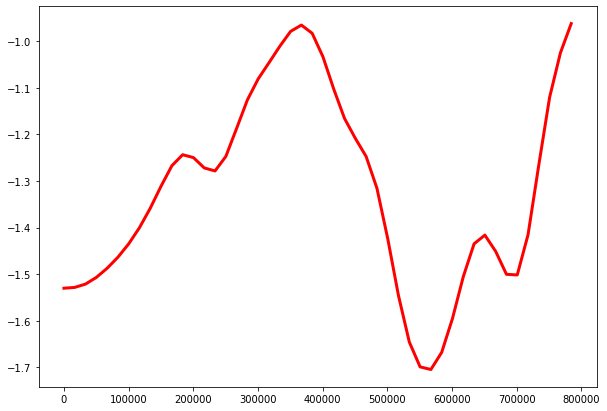

In [214]:
# Evaluate relationship between features and log odds
# plot number of observations over time in database

feature = 'new'
bins = np.linspace(train[feature].min(),train[feature].max(),num=100,endpoint=True)

def get_values():
    l0 = pd.cut(train.query('Phenophase_Status==0')[feature],bins).value_counts().sort_index().values
    l1 = pd.cut(train.query('Phenophase_Status==1')[feature],bins).value_counts().sort_index().values
    return (l0,l1)
   
plt.figure(figsize=(10,7))
#doy = np.arange(1,367,1)
y_vals=lambda x, std: gaussian_filter1d(x,std)
vals_0, vals_1 = get_values()
p = vals_1 / (vals_0+vals_1)
plt.plot(bins[:-1],y_vals(np.log(p/(1-p)),2),linewidth=3,color='red')
#plt.plot(bins[:-1],y_vals(p,1),linewidth=3,color='red')

In [249]:
#logmodel = LogisticRegression(solver='lbfgs',penalty='l1',max_iter=10000)
logmodel = LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.5,max_iter=10000)#,class_weight='balanced')
logmodel.fit(x_inter,y_train)

# save the model to disk
#pickle.dump(logmodel, open('logmodel_0608.sav', 'wb'))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# predict test set labels and evaluate performance
def predict(model, x_test, y_test = None, transform_func = lambda x: x):#interaction = None, x_mean = x_mean, x_std = x_std):
        
    x_test = x_test.copy(deep=True)
    
    #if (interaction == None):
    #    predictions = model.predict(scale(x_test))
    #    probs = model.predict_proba(scale(x_test))
    #else:
    #    predictions = model.predict(scale(interaction.fit_transform(x_test)))
    #    probs = model.predict_proba(scale(interaction.fit_transform(x_test)))
    
    predictions = model.predict(transform_func(x_test))
    probs = model.predict_proba(transform_func(x_test))
    
    probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(2)])
    
    if (y_test is not None):
        print (metrics.classification_report(y_test,predictions))
        print ("Accuracy:",metrics.accuracy_score(y_test, predictions))
        #print (probs)
        #print (x_test)
        
        # reform test set to include predictions from model
        x_test['labels'] = y_test
        
    x_test['predictions'] = predictions
    for i,c in enumerate(probs.columns):
        x_test[c] = probs.values[:,i]
        
    return x_test

In [319]:
transform_input = lambda x: scale(interaction.fit_transform(x))
x_test_location_pred = predict(logmodel,x_test_location,y_test=y_test_location,transform_func=transform_input)
x_test_time_pred = predict(logmodel,x_test_time,y_test=y_test_time,transform_func=transform_input)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       751
           1       0.00      0.00      0.00       369

    accuracy                           0.67      1120
   macro avg       0.34      0.50      0.40      1120
weighted avg       0.45      0.67      0.54      1120

Accuracy: 0.6705357142857142
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1184
           1       0.00      0.00      0.00       391

    accuracy                           0.75      1575
   macro avg       0.38      0.50      0.43      1575
weighted avg       0.57      0.75      0.65      1575

Accuracy: 0.7517460317460317


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Evaluate model performance

In [349]:
train.columns

Index(['Individual_ID', 'date', 'Genus', 'Longitude', 'Latitude',
       'Elevation_in_Meters', 'Phenophase_Description', 'Phenophase_Status',
       'Day_of_Year', 'daylength', 'AGDD0_100', 'cum_ppt_100'],
      dtype='object')

In [256]:
np.sum(logmodel.coef_[0]<-1)
#logmodel.coef_[0]

11

In [358]:
from sklearn.metrics import roc_auc_score
print ("LR, time: %lf"%roc_auc_score(y_test_time, logmodel.predict_proba(transform_input(x_test_time))[:,1]))
print ("LR, location: %lf"%roc_auc_score(y_test_location, logmodel.predict_proba(transform_input(x_test_location))[:,1]))
print ("RF, time: %lf"%roc_auc_score(y_test_time, rfmodel.predict_proba(transform_input(x_test_time))[:,1]))
print ("RF, location: %lf"%roc_auc_score(y_test_location, rfmodel.predict_proba(transform_input(x_test_location))[:,1]))

roc

LR, time: 0.718027
LR, location: 0.719516


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


RF, time: 0.724050
RF, location: 0.866177


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


0.7180274504043684

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


Text(0, 0.5, 'True Positive Rate')

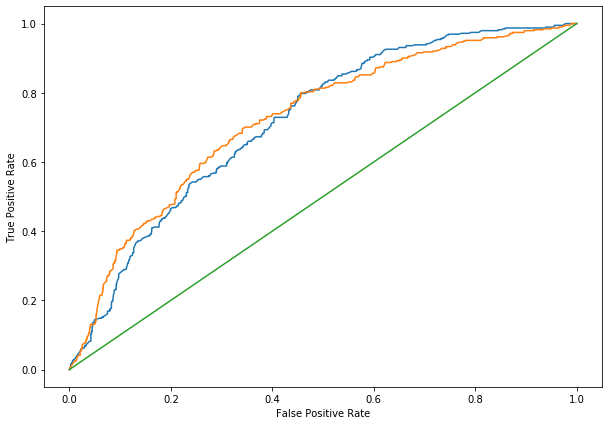

In [356]:
plt.figure(figsize=(10,7))
probs = logmodel.predict_proba(transform_input(x_test_time))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_time, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)

probs = rfmodel.predict_proba(transform_input(x_test_time))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_time, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)

plt.plot(fpr,fpr)
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')

In [226]:
x_test_location_pred.describe()

,Elevation_in_Meters,daylength,AGDD0_100,cum_ppt_100,labels,predictions,probability_0,probability_1
count,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,124.893274,12.615470,1417.013716,221.185546,0.326457,0.643946,0.442999,0.557001
std,88.846671,1.680492,273.343323,233.933657,0.469127,0.479046,0.218828,0.218828
min,0.000000,9.412347,927.271057,0.000000,0.000000,0.000000,0.190982,0.073868
25%,97.000000,11.040022,1216.227051,59.976002,0.000000,0.000000,0.256929,0.355967
50%,112.000000,13.168688,1397.503052,150.432999,0.000000,1.000000,0.322878,0.677122
75%,123.000000,14.186565,1568.977051,333.227997,1.000000,1.000000,0.644033,0.743071
max,722.000000,14.578570,2135.476074,1699.468018,1.000000,1.000000,0.926132,0.809018


Text(0.5, 0, 'Day of Year')

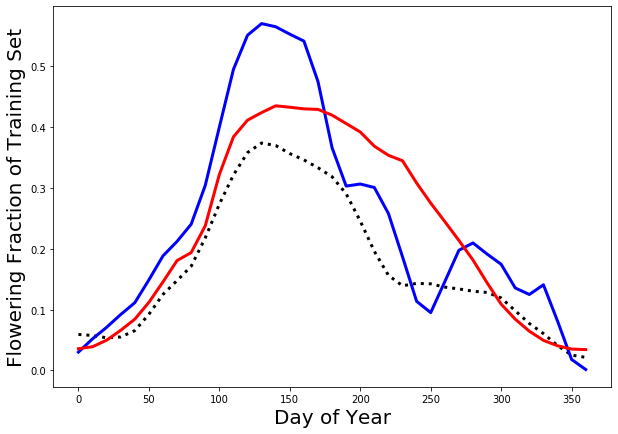

In [338]:
# compare plots of test/pred bloom fraction
def get_values(train):
    l0 = pd.cut(train.query('Phenophase_Status==0').Day_of_Year,np.arange(0,371,10)).value_counts().sort_index().values
    l1 = pd.cut(train.query('Phenophase_Status==1').Day_of_Year,np.arange(0,371,10)).value_counts().sort_index().values
    return (l0,l1)
    
doy = np.arange(0,370,10)#np.arange(1,367,1)

y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

train_0, train_1 = get_values(train)
train_location_0, train_location_1 = get_values(train.query('-122.5 < Longitude < -121.5 and 37.5 < Latitude < 38.5'))
x_test_location_0 = pd.cut(x_test_location_doy[x_test_location_pred.labels==0],np.arange(0,371,10)).value_counts().sort_index().values
x_test_location_1 = pd.cut(x_test_location_doy[x_test_location_pred.labels==1],np.arange(0,371,10)).value_counts().sort_index().values

x_test_location_pred['bucket'] = pd.cut(x_test_location_doy,np.arange(0,371,10))
x_test_location_pred_plot = x_test_location_pred.groupby(['bucket']).probability_1.mean().values

# plt.plot(doy,y_vals(train_1,4),color='green',label="Initial growth")
plt.plot(doy,y_vals(train_1/(train_1+train_0),1),linestyle=':',linewidth=3,color='black',label="Flowering Fraction")
#plt.plot(doy,y_vals(train_location_1/(train_location_1+train_location_0),1),linewidth=2,color='gray',label="Flowering Fraction")
plt.plot(doy,y_vals(x_test_location_1/(x_test_location_0+x_test_location_1),1),linestyle='solid',linewidth=3,color='blue',label="Location, True")
plt.plot(doy,y_vals(x_test_location_pred_plot,.5),linestyle='solid',linewidth=3,color='red',label="Location, Pred")
#plt.plot(doy,y_vals(get_values(['Fruits','Ripe fruits','Recent fruit or seed drop'])/total_yes_obs,4),color='brown',label="Mature fruits")
#plt.plot(doy,y_vals(get_values(['Colored leaves','Falling leaves'])/total_yes_obs,4),color='orange',label="Colored/Falling leaves")

plt.ylabel('Flowering Fraction of Training Set',fontsize=20)
plt.xlabel('Day of Year',fontsize=20)
#plt.title('Phenophase Progression',fontsize=20)
#plt.legend(fontsize=20);

/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


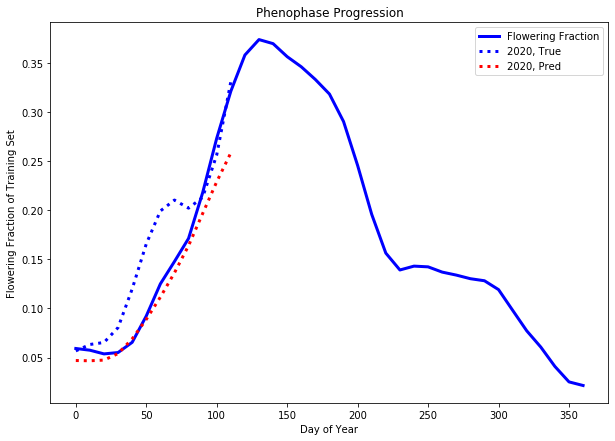

In [321]:
# compare plots of test/pred bloom fraction
def get_values(train):
    l0 = pd.cut(train.query("Phenophase_Status==0").Day_of_Year,np.arange(0,371,10)).value_counts().sort_index().values
    l1 = pd.cut(train.query("Phenophase_Status==1").Day_of_Year,np.arange(0,371,10)).value_counts().sort_index().values
    return (l0,l1)
    
doy = np.arange(0,370,10)#np.arange(1,367,1)

y_vals=lambda x, std: gaussian_filter1d(x,std)

plt.figure(figsize=(10,7))

train_0, train_1 = get_values(train)
x_test_time_0 = pd.cut(x_test_time_doy[x_test_time_pred.labels==0],np.arange(0,371,10)).value_counts().sort_index().values
x_test_time_1 = pd.cut(x_test_time_doy[x_test_time_pred.labels==1],np.arange(0,371,10)).value_counts().sort_index().values

x_test_time_pred['bucket'] = pd.cut(x_test_time_doy,np.arange(0,371,10))
x_test_time_pred_plot = x_test_time_pred.groupby(['bucket']).probability_1.mean().values

# plt.plot(doy,y_vals(train_1,4),color='green',label="Initial growth")
plt.plot(doy,y_vals(train_1/(train_1+train_0),1),linewidth=3,color='blue',label="Flowering Fraction")
plt.plot(doy,y_vals(x_test_time_1/(x_test_time_0+x_test_time_1),1),linestyle=':',linewidth=3,color='blue',label="2020, True")
plt.plot(doy,y_vals(x_test_time_pred_plot,1),linestyle=':',linewidth=3,color='red',label="2020, Pred")
#plt.plot(doy,y_vals(get_values(['Fruits','Ripe fruits','Recent fruit or seed drop'])/total_yes_obs,4),color='brown',label="Mature fruits")
#plt.plot(doy,y_vals(get_values(['Colored leaves','Falling leaves'])/total_yes_obs,4),color='orange',label="Colored/Falling leaves")

plt.ylabel('Flowering Fraction of Training Set')
plt.xlabel('Day of Year')
plt.title('Phenophase Progression')
plt.legend();

In [377]:
x_test_location_pred.describe()

,Elevation_in_Meters,daylength,AGDD0_100,cum_ppt_100,labels,predictions,probability_0,probability_1
count,1122.000000,1122.000000,1122.000000,1122.000000,1122.00000,1122.0,1122.000000,1122.000000
mean,124.635472,12.590807,1420.272070,220.949828,0.33066,0.0,0.738622,0.261378
std,88.690281,1.717503,270.882085,238.747701,0.47066,0.0,0.134373,0.134373
min,0.000000,9.412347,927.271057,0.000000,0.00000,0.0,0.538823,0.064012
25%,97.000000,10.915316,1222.562012,61.602001,0.00000,0.0,0.606713,0.121727
50%,112.000000,13.143091,1397.155029,153.964005,0.00000,0.0,0.719999,0.280001
75%,123.000000,14.194795,1568.733551,332.765991,1.00000,0.0,0.878273,0.393287
max,722.000000,14.585418,2135.476074,1699.468018,1.00000,0.0,0.935988,0.461177


In [339]:
logmodel.coef_[0]

array([ 1.15370731,  2.09593661,  0.08958366,  1.306412  ,  0.32169021,
       -1.20254988, -0.11625906,  0.        ,  0.37265589,  1.36056059,
        0.42171767,  1.2412415 ,  0.10159552, -1.56562574,  0.08422775,
       -0.04653619, -0.80974268,  0.        , -1.3411883 , -0.01637406,
       -0.32753866,  0.63899352, -1.09169106, -1.24630798,  0.        ,
        0.57269652,  0.        ,  0.        ,  0.        , -0.02508212,
        0.25635591, -1.50103653,  1.07829978, -1.46645495, -1.2102637 ,
        1.09376637,  1.23749213, -0.68691141,  0.05056822, -0.88768947,
        0.9236066 , -0.09696806, -0.1988239 ,  0.30172211,  0.3946632 ,
        0.51483436,  0.88548881,  0.        ,  1.0699087 , -0.15200585,
       -0.31271742,  0.14573022,  0.36208637,  0.66813043, -1.01860443,
       -0.64638607, -1.2019865 , -2.16508192, -0.37604123,  0.61287546,
       -0.65043904,  0.87807414,  1.12020633, -0.01024894,  0.04723295,
        0.49376614, -0.70125408, -0.54144001,  1.10887838])

#### Random Forest Approach

In [311]:
# train and predict using random forest
rfmodel = RandomForestClassifier(n_estimators=200,max_depth=15,min_samples_leaf=15,random_state=50,max_features='sqrt',n_jobs=-1,verbose=1)
rfmodel.fit(transform_input(x_train),y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [312]:
x_test_location_pred = predict(rfmodel,x_test_location,y_test=y_test_location,transform_func=transform_input)
x_test_time_pred = predict(rfmodel,x_test_time,y_test=y_test_time,transform_func=transform_input)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.80      0.91      0.85       751
           1       0.75      0.52      0.61       369

    accuracy                           0.78      1120
   macro avg       0.77      0.72      0.73      1120
weighted avg       0.78      0.78      0.77      1120

Accuracy: 0.7848214285714286


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1184
           1       0.44      0.06      0.11       391

    accuracy                           0.75      1575
   macro avg       0.60      0.52      0.48      1575
weighted avg       0.68      0.75      0.67      1575

Accuracy: 0.7479365079365079


In [673]:
print (x_test_location_pred.describe()[['labels','probability_0','probability_1']])
print (x_test_time_pred.describe()[['labels','probability_0','probability_1']])

            labels  probability_0  probability_1
count  1113.000000    1113.000000    1113.000000
mean      0.336029       0.580966       0.419034
std       0.472561       0.333894       0.333894
min       0.000000       0.001155       0.000000
25%       0.000000       0.255032       0.074448
50%       0.000000       0.602724       0.397276
75%       1.000000       0.925552       0.744968
max       1.000000       1.000000       0.998845
            labels  probability_0  probability_1
count  1574.000000    1574.000000    1574.000000
mean      0.243329       0.749486       0.250514
std       0.429228       0.190036       0.190036
min       0.000000       0.208890       0.001422
25%       0.000000       0.609902       0.096389
50%       0.000000       0.814974       0.185026
75%       0.000000       0.903611       0.390098
max       1.000000       0.998578       0.791110


### Predict Park Bloom Rates

This is approximately what we will be doing in the webapp.

Lets try loading in park data, then selecting date and looking up elevation, agdd, and ppt data.

Then, predict bloom from model.

In [158]:
x_test

,Elevation_in_Meters,Day_of_Year,AGDD0_100,labels,predictions,probability_0,probability_1
2154999,256.0,141,1657.948120,1,0,0.803924,0.196076
1658211,1180.0,121,1040.605103,0,0,0.802539,0.197461
1600288,1265.0,52,871.567017,0,0,0.788859,0.211141
496688,346.0,152,1685.528076,0,0,0.814208,0.185792
876848,338.0,41,1303.318115,0,0,0.765453,0.234547
...,...,...,...,...,...,...,...
1087530,277.0,282,2384.895020,0,0,0.878539,0.121461
2445607,80.0,227,2195.147217,0,0,0.849940,0.150060
825157,1920.0,265,1942.831055,0,0,0.922137,0.077863
1723770,259.0,201,1262.325073,0,0,0.750538,0.249462


In [392]:
# load parks df
parks = pd.read_pickle('parks.pkl')
#visit_date = date(2020,4,1)

In [393]:
parks_full = []

start = date(2020, 1, 1)
end = date(2020, 12, 31)
delta = end - start       # as timedelta

dates = []

count = 0
for i in range(delta.days + 1):
    day = start + timedelta(days=i)
    dates.append(day)
    count += 1 
    parksi = parks.copy(deep=True)
    parksi['Day_of_Year'] = day.timetuple().tm_yday
    parksi['daylength'] = parksi.apply(lambda x: daylength(x.Day_of_Year,x.Latitude),axis=1)
    
    # lookup agdd
    parksi['AGDD0_100'] = np.nan
    agdd_path = 'prism/daily/agdd0/%s/PRISM_agdd0_%s%02d%02d.tif'
    
    # read in aggd0 file
    agdd_data = raster_dataset(agdd_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
    parksi['AGDD0_100'] = parksi.apply(lambda x: agdd_data.get_value(x.Longitude,x.Latitude), axis=1)

    # lookup cum_ppt_100
    parksi['cum_ppt_100'] = np.nan
    cum_ppt_100_path = 'prism/daily/cum_ppt_100/%s/PRISM_cum_ppt_100_%s%02d%02d.tif'
    
    # read in aggd0 file
    cum_ppt_100_data = raster_dataset(cum_ppt_100_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
    parksi['cum_ppt_100'] = parksi.apply(lambda x: cum_ppt_100_data.get_value(x.Longitude,x.Latitude), axis=1)
    
    parks_full.append(parksi)




In [394]:
parks_full = pd.concat(parks_full).reset_index()

In [395]:
parks_full.to_pickle('parks_full.pkl')

In [396]:
parks

,Name,Latitude,Longitude,elevation_srtm
0,Ahjumawi Lava Springs State Park,41.121537,-121.451396,1030
1,Andrew Molera State Park,36.279646,-121.830951,25
2,Angel Island State Park,37.862930,-122.430364,181
3,Annadel State Park,38.426131,-122.624343,286
4,Anza-Borrego Desert State Park,33.095535,-116.301898,549
...,...,...,...,...
179,Sweetwater Marsh National Wildlife Refuge,32.641032,-117.111598,3
180,Washoe Meadows State Park,38.876651,-120.029260,1935
181,Carrizo Plain National Monument,35.189908,-119.862997,599
182,Snow Mountain Wilderness,39.403534,-122.740587,1732


In [757]:
#parks['Day_of_Year'] = visit_date.timetuple().tm_yday
#parks['daylength'] = parks.apply(lambda x: daylength(x.Day_of_Year,x.Latitude),axis=1)

In [174]:
# lookup agdd
#parks['AGDD0_100'] = np.nan
#agdd_path = 'prism/daily/agdd0/%s/PRISM_agdd0_%s%02d%02d.tif'

# read in aggd0 file
#agdd_data = raster_dataset(agdd_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
#parks['AGDD0_100'] = parks.apply(lambda x: agdd_data.get_value(x.Longitude,x.Latitude), axis=1)

In [175]:
# load the model from disk
logmodel = pickle.load(open('logmodel_0608.sav', 'rb'))

predictions = logmodel.predict(parks[['elevation_srtm','Day_of_Year','AGDD0_100']])
probs = logmodel.predict_proba(parks[['elevation_srtm','Day_of_Year','AGDD0_100']])
probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(2)])

#print (metrics.classification_report(y_test,predictions))
#print ("Accuracy:",metrics.accuracy_score(y_test, predictions))
#print (probs)
#print (parks)

# reform test set to include predictions from model
#parks['labels'] = y_test
parks['predictions'] = predictions
for i,c in enumerate(probs.columns):
    parks[c] = probs.values[:,i]
    
parks.describe()

,Latitude,Longitude,elevation_srtm,Day_of_Year,AGDD0_100,predictions,probability_0,probability_1
count,160.000000,160.000000,160.000000,160.0,160.000000,160.0,160.000000,160.000000
mean,37.613472,-120.756284,622.175000,92.0,846.671664,0.0,0.723917,0.276083
std,2.523253,2.378756,731.824897,0.0,409.252496,0.0,0.035683,0.035683
min,32.556380,-124.249611,-71.000000,92.0,-362.808014,0.0,0.640586,0.194758
25%,35.583148,-122.412927,50.750000,92.0,686.661789,0.0,0.695061,0.252880
50%,37.884543,-121.120737,290.500000,92.0,982.318024,0.0,0.720432,0.279568
75%,39.345693,-119.501331,1066.750000,92.0,1074.496277,0.0,0.747120,0.304939
max,41.887569,-111.888969,3346.000000,92.0,1580.560059,0.0,0.805242,0.359414


In [127]:
# lets check how predicted labels compare to the data
#data[data.Phenophase_Description.isin(flowers)&(data.date.dt.year==2017)].query('0 < Elevation_in_Meters < 50 and 170 < Day_of_Year < 180 and Phenophase_Status != -1').groupby('Individual_ID').count()
#data.loc[data[data.date.dt.year==2017].query('0 < Elevation_in_Meters < 50 and 100 < Day_of_Year < 110').Phenophase_Description.isin(flowers)]


for k,g in data.groupby(['Individual_ID','date']):
    print (k)
    print (g)
    break

(2792, Timestamp('2017-03-14 00:00:00'))
            date  Submission_ID   Latitude   Longitude  Elevation_in_Meters  \
10659 2017-03-14        1122642  39.289673 -123.373718                212.0   
10683 2017-03-14        1122642  39.289673 -123.373718                212.0   
10691 2017-03-14        1122642  39.289673 -123.373718                212.0   
10699 2017-03-14        1122642  39.289673 -123.373718                212.0   
10707 2017-03-14        1122642  39.289673 -123.373718                212.0   

           Genus     Species       Common_Name Species_Functional_Type  \
10659  Taraxacum  officinale  common dandelion                    Forb   
10683  Taraxacum  officinale  common dandelion                    Forb   
10691  Taraxacum  officinale  common dandelion                    Forb   
10699  Taraxacum  officinale  common dandelion                    Forb   
10707  Taraxacum  officinale  common dandelion                    Forb   

      Species_Category  ...     Phenoph

## Adding Complete Elevation Data

In [265]:
elevation_filename = lambda a: 'srtm/srtm_%s/srtm_%s.tif'%(a,a)
elev = rasterio.open(elevation_filename('12_04'))
coords = (-123.004553,37.999545)
vals=elev.sample(coords)

In [266]:
src = {}
src_coord = {}
lonlat = {}
elevation_data = {}

def get_gps (row, col):
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(src_coord, lonlat, east, north)
    value = elevation_data[row, col]
    return lon, lat

# input: longitude, latitude (gps coordinate)
# return: elevation_data value at input location(s)
def get_value (lon, lat):
    east,north = pyproj.transform(lonlat, src_coord, lon, lat)

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    #print(f'row,col=\t\t({row},{col})')

    # What is the value at that index?
    value = elevation_data[row, col]
    return value

for a in ['12_04','12_05','12_06','13_04','13_05','13_06','14_05','14_06']:
    src = rasterio.open(elevation_filename(a))
    src_coord = pyproj.Proj(src.crs)
    lonlat = pyproj.Proj(init='epsg:4326')
    elevation_data = src.read(1)
    print (a)
    print (get_gps(0,0))
    print (get_gps(5999,5999))
    print ('---------')

12_04
(-124.99958333333335, 44.99958333333334)
(-120.00041666666667, 40.000416666666666)
---------
12_05
(-124.99958333333335, 39.999583333333334)
(-120.00041666666667, 35.000416666666666)
---------
12_06
(-124.99958333333335, 34.999583333333334)
(-120.00041666666667, 30.000416666666666)
---------
13_04
(-119.99958333333335, 44.99958333333334)
(-115.00041666666667, 40.000416666666666)
---------
13_05
(-119.99958333333335, 39.999583333333334)
(-115.00041666666667, 35.000416666666666)
---------
13_06
(-119.99958333333335, 34.999583333333334)
(-115.00041666666667, 30.000416666666666)
---------
14_05
(-114.99958333333333, 39.999583333333334)
(-110.00041666666667, 35.000416666666666)
---------
14_06
(-114.99958333333333, 34.999583333333334)
(-110.00041666666667, 30.000416666666666)
---------


In [71]:
steps_lat = 200.
step_size_lat = (42.14-32.41)/steps_lat
steps_lon = (125.19-113.85)/step_size_lat
print (steps_lat)
print (steps_lon)

200.0
233.0935251798561


In [267]:
# lookup elevation
grid = np.mgrid[32.41:42.14:200j,-125.19:-113.85:233j]

# extract the x and y coordinates as flat arrays
grid_lat = np.ravel(grid[0])
grid_lon = np.ravel(grid[1])

# using the X and Y columns, build a dataframe, then the geodataframe
grid_df = pd.DataFrame({'Lat':grid_lat, 'Lon':grid_lon})
grid_df['coords'] = list(zip(grid_df['Lon'],grid_df['Lat']))
grid_df['coords'] = grid_df['coords'].apply(Point)
#grid_gdf = gpd.GeoDataFrame(grid_df, geometry='coords')

valid_points = np.where(np.array([ca.contains(p) for p in grid_df.coords.values]))
grid_df = grid_df.loc[valid_points[0]]

print (grid_df)

             Lat         Lon                                        coords
863    32.556683 -117.173793  POINT (-117.1737931034483 32.55668341708542)
864    32.556683 -117.124914  POINT (-117.1249137931034 32.55668341708542)
865    32.556683 -117.076034  POINT (-117.0760344827586 32.55668341708542)
866    32.556683 -117.027155  POINT (-117.0271551724138 32.55668341708542)
867    32.556683 -116.978276   POINT (-116.978275862069 32.55668341708542)
...          ...         ...                                           ...
45770  41.993317 -120.204310  POINT (-120.2043103448276 41.99331658291457)
45771  41.993317 -120.155431  POINT (-120.1554310344828 41.99331658291457)
45772  41.993317 -120.106552  POINT (-120.1065517241379 41.99331658291457)
45773  41.993317 -120.057672  POINT (-120.0576724137931 41.99331658291457)
45774  41.993317 -120.008793  POINT (-120.0087931034483 41.99331658291457)

[18068 rows x 3 columns]


In [268]:
# first, mark which srtm file to lookup
srtm_lon_index = np.floor((grid_df.Lon+125.0000001)/5).astype(np.int).map({0:12,1:13,2:14})
srtm_lat_index = np.floor((grid_df.Lat-30.000417)/5).astype(np.int).map({0:6,1:5,2:4})

grid_df['elevation_srtm'] = -9999

for a in ['12_04','12_05','12_06','13_04','13_05','13_06','14_05','14_06']:
    lon_i,lat_i = a.split('_')
    src = rasterio.open(elevation_filename(a))
    src_coord = pyproj.Proj(src.crs)
    lonlat = pyproj.Proj(init='epsg:4326')
    elevation_data = src.read(1)
    # get all observations for this map
    #print (a+":")
    _grid_df = grid_df[(srtm_lon_index==int(lon_i))&(srtm_lat_index==int(lat_i))]
    elevation = get_value(_grid_df.Lon.values,_grid_df.Lat.values)
    grid_df.loc[_grid_df.index,'elevation_srtm'] = elevation
    #print (len(elevation))

grid_df = grid_df[grid_df.elevation_srtm>-500]

In [ ]:
grid_df.to_pickle('grid_df.pkl')

In [283]:
# generate probabilities from model
# need to add day of year to grid_df
visit_date = date(2020,5,15)
grid_df['Day_of_Year'] = visit_date.timetuple().tm_yday

grid_df['daylength'] = grid_df.apply(lambda x: daylength(x.Day_of_Year,x.Lat),axis=1)

grid_df['AGDD0_100'] = np.nan
agdd_path = 'prism/daily/agdd0/%s/PRISM_agdd0_%s%02d%02d.tif'

# read in aggd0 file
agdd_data = raster_dataset(agdd_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
grid_df['AGDD0_100'] = grid_df.apply(lambda x: agdd_data.get_value(x.Lon,x.Lat), axis=1)

grid_df['cum_ppt_100'] = np.nan
cum_ppt_100_path = 'prism/daily/cum_ppt_100/%s/PRISM_cum_ppt_100_%s%02d%02d.tif'

# read in aggd0 file
cum_ppt_100_data = raster_dataset(cum_ppt_100_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
grid_df['cum_ppt_100'] = grid_df.apply(lambda x: cum_ppt_100_data.get_value(x.Lon,x.Lat), axis=1)

grid_df_pred = predict(logmodel,grid_df[['elevation_srtm','daylength','AGDD0_100','cum_ppt_100']],transform_func=transform_input)

In [586]:
#predictions = logmodel.predict(scale(interaction.fit_transform(grid_df[['elevation_srtm','daylength','AGDD0_100','cum_ppt_100']])))
#probs = logmodel.predict_proba(scale(interaction.fit_transform(grid_df[['elevation_srtm','daylength','AGDD0_100','cum_ppt_100']])))
#probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(2)])
#grid_df['predictions'] = predictions
#for i,c in enumerate(probs.columns):
#    grid_df[c] = probs.values[:,i]

In [316]:
grid_df_pred.probability_1.describe()
#geo_df

count    17455.000000
mean         0.359507
std          0.153193
min          0.004498
25%          0.268096
50%          0.360296
75%          0.457160
max          0.748995
Name: probability_1, dtype: float64

In [289]:
for i in range(0,366):
    print (date(2020,1,1)+timedelta(days=i))

2020-01-01
2020-01-02
2020-01-03
2020-01-04
2020-01-05
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-11
2020-01-12
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-18
2020-01-19
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-26
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-01
2020-02-02
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-08
2020-02-09
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-15
2020-02-16
2020-02-17
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-22
2020-02-23
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-02-29
2020-03-01
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-07
2020-03-08
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-14
2020-03-15
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-29
2020-03-30
2020-03-31

In [300]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [324]:
date(2019,1,1).strftime("%b")

'Jan'

In [328]:
# generate probabilities from model
# need to add day of year to grid_df
for i in range(208,280):
    #i=150
    #print (date(2020,1,1)+timedelta(days=i))
    visit_date = date(2020,1,1)+timedelta(days=i)
    #visit_date = date(2020,5,15)
    grid_df['Day_of_Year'] = visit_date.timetuple().tm_yday
    
    grid_df['daylength'] = grid_df.apply(lambda x: daylength(x.Day_of_Year,x.Lat),axis=1)
    
    grid_df['AGDD0_100'] = np.nan
    agdd_path = 'prism/daily/agdd0/%s/PRISM_agdd0_%s%02d%02d.tif'
    
    # read in aggd0 file
    agdd_data = raster_dataset(agdd_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
    grid_df['AGDD0_100'] = grid_df.apply(lambda x: agdd_data.get_value(x.Lon,x.Lat), axis=1)
    
    grid_df['cum_ppt_100'] = np.nan
    cum_ppt_100_path = 'prism/daily/cum_ppt_100/%s/PRISM_cum_ppt_100_%s%02d%02d.tif'
    
    # read in aggd0 file
    cum_ppt_100_data = raster_dataset(cum_ppt_100_path % (visit_date.year,visit_date.year,visit_date.month,visit_date.day))
    grid_df['cum_ppt_100'] = grid_df.apply(lambda x: cum_ppt_100_data.get_value(x.Lon,x.Lat), axis=1)
    
    grid_df_pred = predict(logmodel,grid_df[['elevation_srtm','daylength','AGDD0_100','cum_ppt_100']],transform_func=transform_input)
    
    # plot unique GPS locations
    #geometry = plot_data.apply(lambda x: Point((x.Longitude,x.Latitude)),axis=1)
    geo_df = gpd.GeoDataFrame(grid_df_pred,crs=crs,geometry=grid_df.coords.values)
    
    fig,ax = plt.subplots(figsize=(20,20))
    ca.plot(ax=ax,alpha=0.3,color='grey',edgecolor='green')
    #geo_df.plot(ax=ax,markersize=20,color='blue')
    
    norm = matplotlib.colors.Normalize(vmin=0.0,vmax=.55)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
    #tmp = geo_df[geo_df['probability_1']>exclude]
    colors = [mapper.to_rgba(x) for x in geo_df.probability_1.values]
    geo_df.plot(ax=ax,markersize=40,c=colors,label='0',alpha=0.4)
    
    #geo_df.plot(ax=ax,markersize=10,color='green')
    #plt.title('Observations Recorded in California')
    plt.title('%s %d, %d'%(visit_date.strftime("%b"),visit_date.day,visit_date.year),fontsize=30)
    plt.legend();
    #plt.colorbar(mapper)#, fraction=0.1,orientation='vertical')
    #break
    #last_axes = plt.gca()
    #ax = mappable.axes
    #fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mapper, cax=cax)

    plt.savefig('ca_pred_%d_%03d-2.png'%(visit_date.year,visit_date.timetuple().tm_yday))
    plt.close()
    #break